<img src="https://www.nus.edu.sg/images/default-source/identity-images/NUS_logo_full-horizontal.jpg" style="float: left; margin: 5px; height: 120px">

# DSA5344_Group33: Track 2: Loan-level Anomaly Detection for Repayment Behavior
#### Members: Jia Sheng |  Hu Qingxuan | Gong Zihong

 - [Problem Statement](#Problem-Statement)
 - [Methodology](#Methodology)
 - [Data Import](#Data-Import)
 - [Exploratory Data Analysis](#Exploratory-Data-Analysis)
 - [Citations and Sources](#Citations-and-Sources)

## Problem Statement

Financial institutions face significant losses from loan defaults each year. Current credit scoring models primarily evaluate borrower characteristics at loan origination, missing behavioral patterns that emerge during the repayment lifecycle. Typical credit scoring models are developed from static windows, and are therefore quite insensitive to changes, such as population changes or disturbances in periods of major financial distress (Sousa et al., 2016).

This project develops machine learning models (non-deep learning models) to detect abnormal repayment behavior by analyzing both static borrower information and temporal payment sequences. The approach combines domain-specific feature engineering with ensemble anomaly detection models.
The objective is to identify loans that will eventually miss scheduled payments by analyzing their repayment trajectories and borrower characteristics. Each loan contains static features (borrower demographics, loan terms, credit scores) and temporal sequences representing monthly loan status and balance information over exactly 14 months. The target variable indicates payment outcomes, where 0 represents successful payment and 1 represents default

The primary challenges include severe class imbalance (only 12.6% of validation loans are problematic), mixed data types, and computational efficiency requirements for processing/training large loan dataset with unsupervised models. This Kaggle competition focuses on Average Precision over AUC for imbalanced data. This makes sense as high precision reduces the business cost of wrongly flagging good customers as defaults.


## Methodology 

Following Blitzstein & Pfister's workflow, a 5-step framework was implemented to conduct this analysis:

**Step 1: Ask an interesting question**
- Define a clear and concise problem statement
- Identify the unsupervised anomaly detection challenge in loan repayment behavior

**Step 2: Get the data**
- Import raw loan performance data (train, validation, test sets)
- Verify data structure and temporal dimensions (14-month observation window)
- Confirm target variable distribution across datasets

**Step 3: Explore the data**
- Data quality checks: missing values, duplicates, data types
- Target variable analysis: identify class distribution and modeling approach requirements
- Payment behavior patterns:
  - Payment ratios relative to scheduled payments
  - Temporal trends: early vs late period behavior
  - Balance trajectories and principal reduction rates
- Statistical pattern analysis:
  - Distribution metrics (skewness, kurtosis, percentiles)
  - Payment irregularity indicators
  - Consecutive pattern detection (streaks, changes)
- Credit risk profile:
  - Static origination features (credit score, DTI, LTV)
  - Risk flag combinations
  - Relationship between static and behavioral features

**Step 4: Model the data**

*4.1 Feature Engineering*
- Design 7 feature groups capturing different behavioral dimensions:
  - baseline_payment: payment ratios and windowed statistics
  - payment_velocity: principal reduction rates and trends
  - payment_irregularity: underpayment flags and streak detection
  - balance_trajectory: balance evolution and stagnation metrics
  - credit_risk: traditional origination risk factors
  - temporal_changes: behavioral shifts over time (early vs late)
  - advanced_patterns: statistical distribution signatures
- Implement preprocessing pipeline: outlier clipping, imputation, scaling (fitted on training set only)

*4.2 Baseline Modeling*
- Test individual feature groups with ensemble of unsupervised anomaly detectors:
  - Density-based: Local Outlier Factor (LOF) with multiple configurations
  - Boundary-based: One-Class SVM
  - Statistical: ECOD, COPOD, HBOS, LODA
  - Distance-based: KNN, COF
  - Ensemble: Isolation-based methods (INNE)
  - Clustering-based: CBLOF
- Iteratively build best feature combination using greedy forward selection
- Establish baseline with simple average ensemble (equal weights)

*4.3 Hyperparameter Tuning*
- Contamination parameter tuning across multiple values
- Ensemble weight optimization using iterative grid search
- Model selection based on validation performance (Average Precision metric)

**Step 5: Communicate and visualize results**
- Performance comparison across optimization stages
- Feature group contribution analysis
- Model interpretation and key behavioral indicators
- Generate test predictions with probability calibration
- Export model configuration for reproducibility

## Data Import

In [ ]:
!pip install pandas ipywidgets sweetviz pandas setuptools seaborn scikit-learn plotly ydata-profiling pyod

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats

# ML libraries
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Optional libraries
# import sweetviz as sv
from ydata_profiling import ProfileReport

# PyOD models
try:
    from pyod.models.ecod import ECOD
    from pyod.models.copod import COPOD
    from pyod.models.hbos import HBOS
    from pyod.models.knn import KNN
    from pyod.models.inne import INNE
    from pyod.models.cblof import CBLOF
    from pyod.models.loda import LODA
    from pyod.models.cof import COF
    PYOD_AVAILABLE = True
except ImportError:
    PYOD_AVAILABLE = False

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
train_df = pd.read_csv('/home/ubuntu/cs5344/Track2/loans_train.csv', low_memory=False)
valid_df = pd.read_csv('/home/ubuntu/cs5344/Track2/loans_valid.csv', low_memory=False)
test_df = pd.read_csv('/home/ubuntu/cs5344/Track2/loans_test.csv', low_memory=False)

In [4]:
train_df.head()

,index,target,CreditScore,FirstPaymentDate,FirstTimeHomebuyerFlag,MaturityDate,MSA,MI_Pct,NumberOfUnits,OccupancyStatus,...,12_MonthlyReportingPeriod,12_RemainingMonthsToLegalMaturity,13_CurrentActualUPB,13_CurrentInterestRate,13_CurrentNonInterestBearingUPB,13_EstimatedLTV,13_InterestBearingUPB,13_LoanAge,13_MonthlyReportingPeriod,13_RemainingMonthsToLegalMaturity
0,0,0,747,202403,N,205402,NaN,0,1,P,...,202502,348,81190.87,8.000,0.0,999,81190.87,13,202503,347
1,1,0,659,202403,N,205402,NaN,0,1,P,...,202502,348,301932.72,7.875,0.0,64,301932.72,13,202503,347
2,3,0,775,202403,N,205402,46540.0,0,2,I,...,202502,348,152044.42,7.625,0.0,999,152044.42,13,202503,347
3,4,0,815,202403,Y,205402,NaN,25,1,P,...,202502,348,50045.91,7.250,0.0,70,50045.91,13,202503,347
4,6,0,772,202403,N,205402,10900.0,0,1,P,...,202502,348,153521.39,7.750,0.0,63,153521.39,13,202503,347


In [5]:
valid_df.head()

,index,target,CreditScore,FirstPaymentDate,FirstTimeHomebuyerFlag,MaturityDate,MSA,MI_Pct,NumberOfUnits,OccupancyStatus,...,12_MonthlyReportingPeriod,12_RemainingMonthsToLegalMaturity,13_CurrentActualUPB,13_CurrentInterestRate,13_CurrentNonInterestBearingUPB,13_EstimatedLTV,13_InterestBearingUPB,13_LoanAge,13_MonthlyReportingPeriod,13_RemainingMonthsToLegalMaturity
0,2,0,784,202403,N,205402,46540.0,0,1,P,...,202502,348,123552.68,6.750,0.0,69,123552.68,13,202503,347
1,11,0,786,202403,N,205402,15764.0,25,1,P,...,202502,348,605030.78,7.000,0.0,71,605030.78,13,202503,347
2,22,0,739,202403,N,205402,36540.0,0,1,P,...,202502,348,158234.13,7.000,0.0,21,158234.13,13,202503,347
3,38,0,773,202403,N,205402,NaN,0,1,P,...,202502,348,155843.09,6.875,0.0,58,155843.09,13,202503,347
4,39,0,736,202403,Y,205402,NaN,25,1,P,...,202502,348,66226.11,7.250,0.0,88,66226.11,13,202503,347


## Exploratory Data Analysis

#### Value Counts Target Variable for Train dataset

In [6]:
train_df.target.value_counts(normalize=True)

target
0    1.0
Name: proportion, dtype: float64

#### Value Counts Target Variable for Validation dataset

In [7]:
valid_df.target.value_counts(normalize=True)

target
0    0.873929
1    0.126071
Name: proportion, dtype: float64

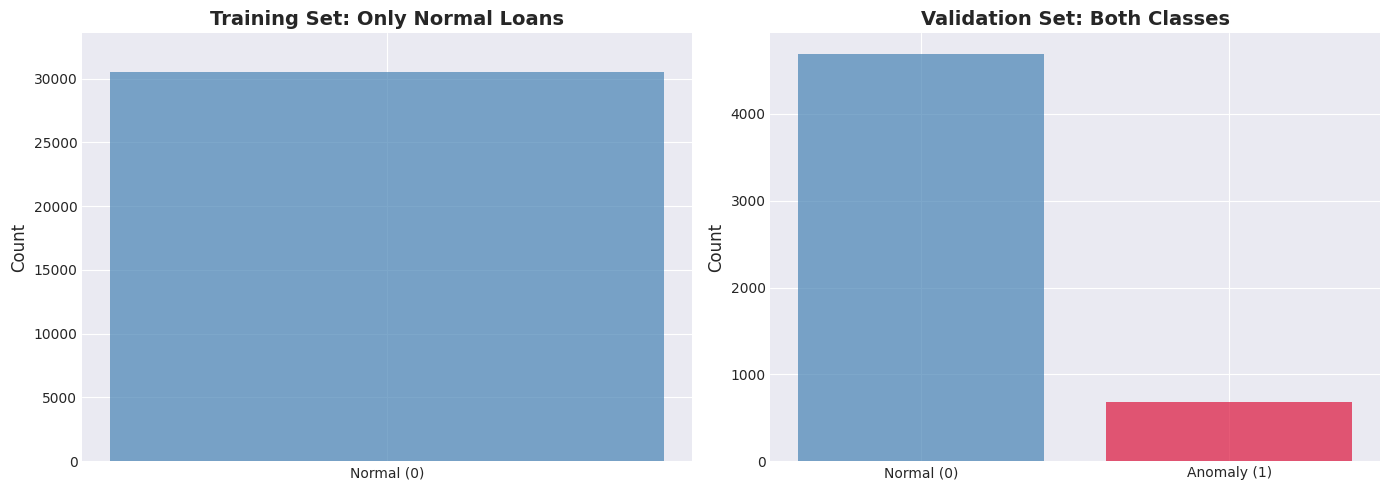

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training
axes[0].bar(['Normal (0)'], [len(train_df)], color='steelblue', alpha=0.7)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Training Set: Only Normal Loans', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, len(train_df) * 1.1)

# Validation
valid_counts = valid_df['target'].value_counts().sort_index()
axes[1].bar(['Normal (0)', 'Anomaly (1)'], valid_counts.values, 
            color=['steelblue', 'crimson'], alpha=0.7)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Validation Set: Both Classes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

#### Missing Values

TOP 20 FEATURES WITH MISSING VALUES:
                          Missing_Count  Missing_Percentage
ReliefRefinanceIndicator          30504          100.000000
PreHARP_Flag                      30504          100.000000
SuperConformingFlag               30176           98.924731
MSA                                3422           11.218201


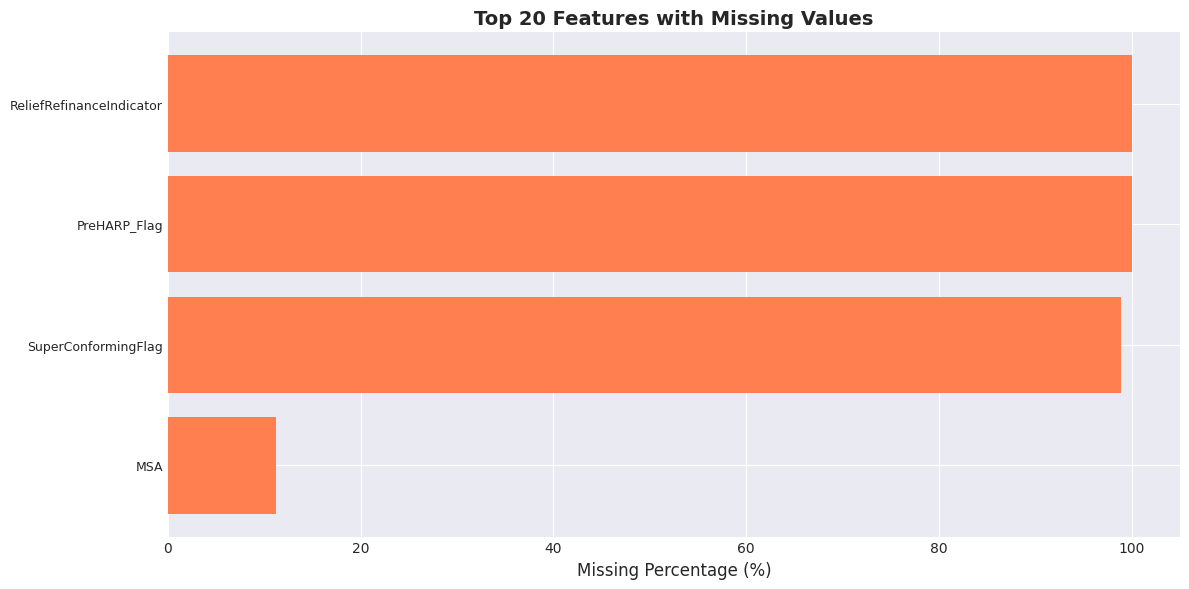

In [9]:
# Missing values in training set
missing_train = train_df.isnull().sum()
missing_train_pct = (missing_train / len(train_df)) * 100
missing_summary = pd.DataFrame({
    'Missing_Count': missing_train[missing_train > 0],
    'Missing_Percentage': missing_train_pct[missing_train > 0]
}).sort_values('Missing_Percentage', ascending=False)

print("TOP 20 FEATURES WITH MISSING VALUES:")
print(missing_summary.head(20))

plt.figure(figsize=(12, 6))
top_missing = missing_summary.head(20)
plt.barh(range(len(top_missing)), top_missing['Missing_Percentage'], color='coral')
plt.yticks(range(len(top_missing)), top_missing.index, fontsize=9)
plt.xlabel('Missing Percentage (%)', fontsize=12)
plt.title('Top 20 Features with Missing Values', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Dataset Overview**:
- Train: 30,504 loans (144 features) | Valid: 5,370 loans | No duplicates
- High missing rates (>99%): ReliefRefinanceIndicator, PreHARP_Flag, SuperConformingFlag
- MSA: 10% missing that requires imputation or flagging techniques

**Target Distribution**:
- Train: 100% normal (class 0) which requires pure unsupervised learning
- Valid: 87.4% normal, 12.6% anomaly (class 1), class imbalance issue is observed.

**Problem Type**: Unsupervised anomaly detection
- Cannot use supervised methods as there are no anomaly examples in training
- Approach: Learn "normal" behavior patterns, flag deviations as anomalies

#### Static Features Analysis

STATIC FEATURES STATISTICS (Training - Normal Loans Only)
             Feature          Mean     Median           Std     Min         Max
         CreditScore    751.130837    760.000     43.897118   600.0     830.000
        OriginalCLTV     75.425125     80.000     19.579456     6.0     105.000
         OriginalDTI     37.801593     40.000      9.317816     2.0      50.000
         OriginalUPB 317095.430108 277000.000 181297.522957 15000.0 1700000.000
         OriginalLTV     75.186205     80.000     19.433155     6.0      97.000
OriginalInterestRate      6.720708      6.625      0.551169     2.5       9.125
    OriginalLoanTerm    349.134409    360.000     42.439446    85.0     360.000


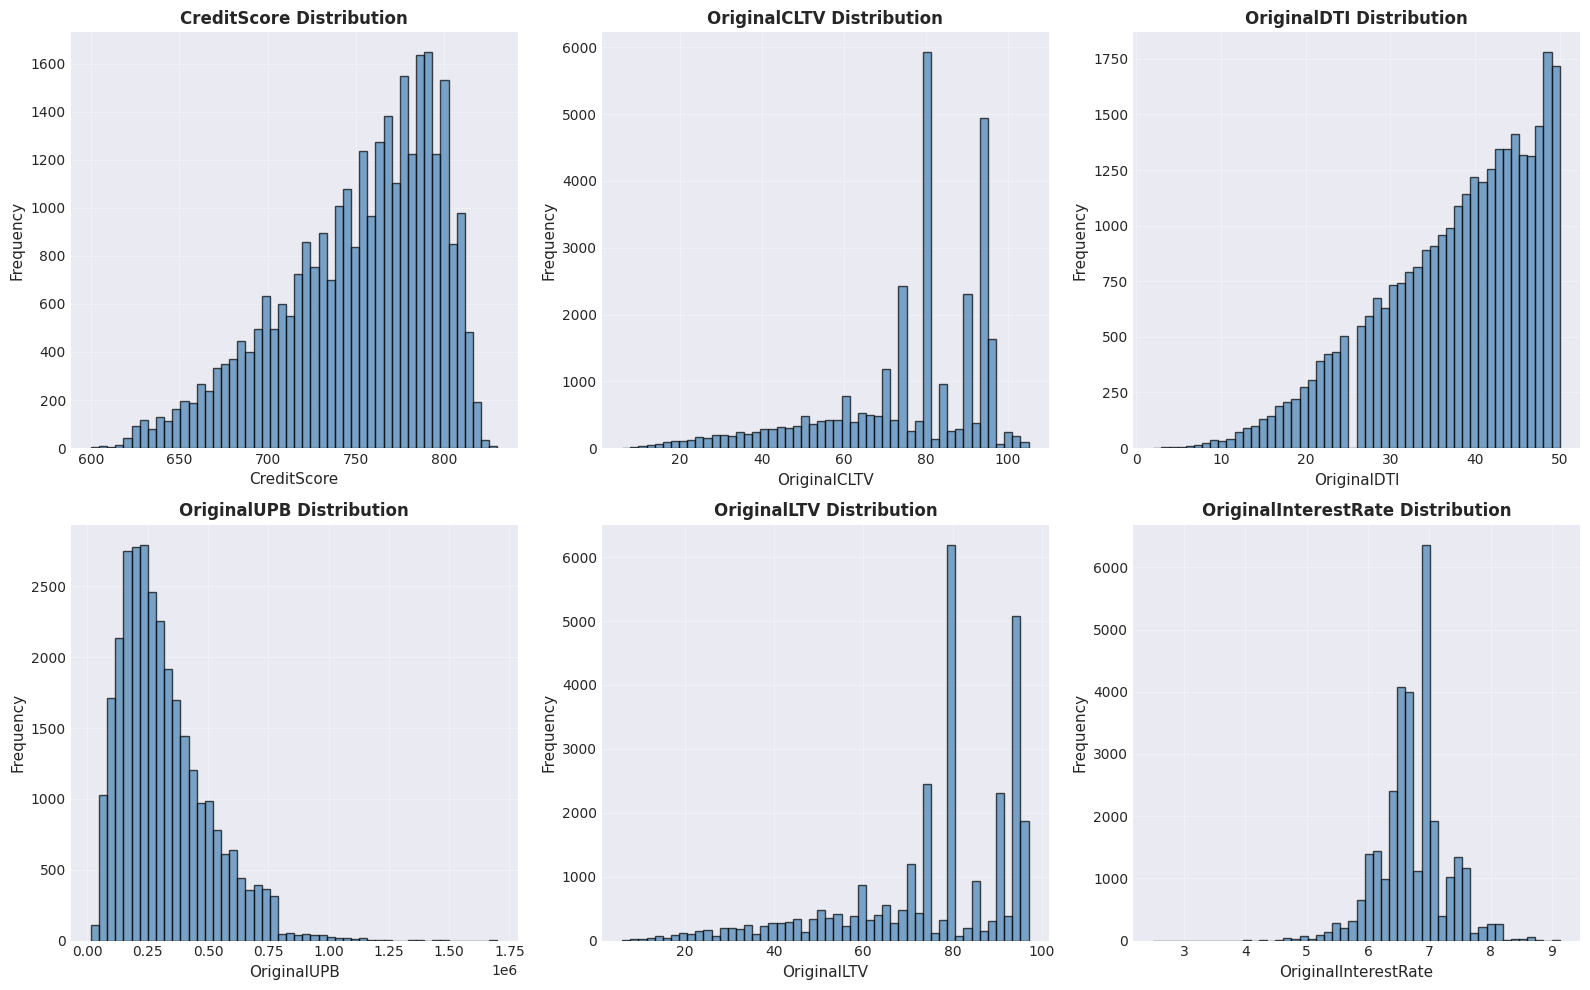

In [10]:
key_static = ['CreditScore', 'OriginalCLTV', 'OriginalDTI', 'OriginalUPB', 
              'OriginalLTV', 'OriginalInterestRate', 'OriginalLoanTerm']

print("STATIC FEATURES STATISTICS (Training - Normal Loans Only)")
print("="*80)

stats_data = []
for feature in key_static:
    if feature in train_df.columns:
        if feature == 'CreditScore':
            valid_values = train_df[train_df[feature] != 9999][feature]
        elif feature in ['OriginalDTI', 'OriginalLTV']:
            valid_values = train_df[train_df[feature] != 999][feature]
        else:
            valid_values = train_df[feature].dropna()
        
        stats_data.append({
            'Feature': feature,
            'Mean': valid_values.mean(),
            'Median': valid_values.median(),
            'Std': valid_values.std(),
            'Min': valid_values.min(),
            'Max': valid_values.max()
        })

stats_df = pd.DataFrame(stats_data)
print(stats_df.to_string(index=False))

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(key_static[:6]):
    if feature in train_df.columns:
        if feature == 'CreditScore':
            data = train_df[train_df[feature] != 9999][feature]
        elif feature in ['OriginalDTI', 'OriginalLTV']:
            data = train_df[train_df[feature] != 999][feature]
        else:
            data = train_df[feature].dropna()
        
        axes[idx].hist(data, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        axes[idx].set_xlabel(feature, fontsize=11)
        axes[idx].set_ylabel('Frequency', fontsize=11)
        axes[idx].set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Generate comprehensive profiling report

In [ ]:
train_profile = ProfileReport(
    train_df, 
    title="Loan Training Data - Profiling Report",
    minimal=False,
    explorative=False,  
    interactions=None,  
)

display(train_profile)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 145/145 [00:00<00:00, 33390.47it/s]


##### 1. Indepth EDA: Loan payment ratio analysis

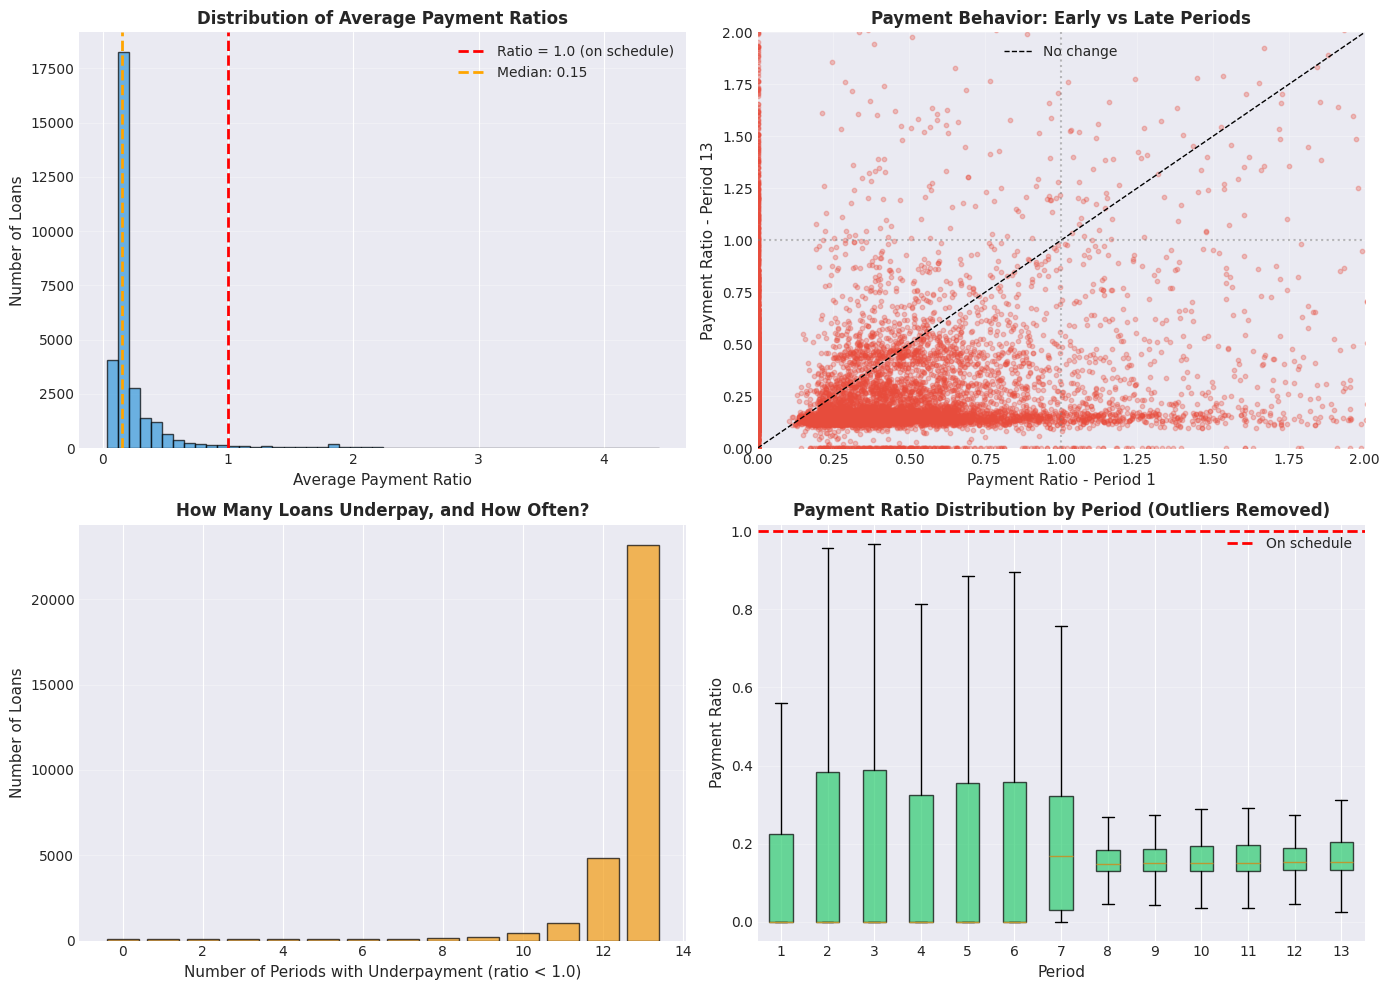

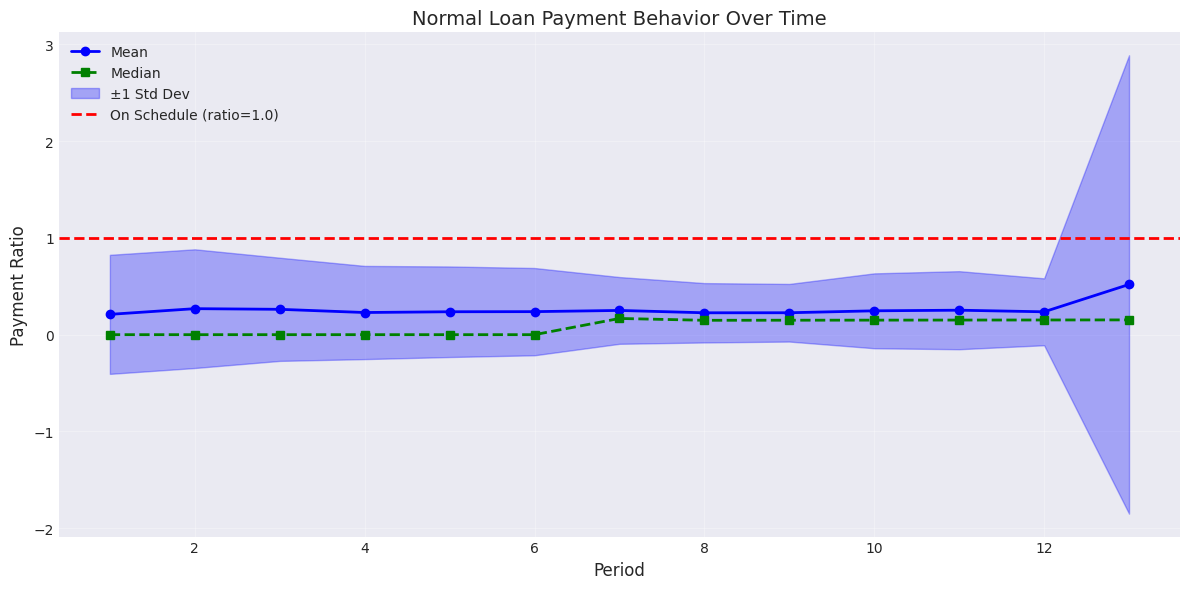

In [ ]:
def calculate_monthly_payment(principal, annual_rate, term_months):
    """Calculate scheduled monthly payment for a loan"""
    monthly_rate = annual_rate / 100 / 12
    if monthly_rate == 0:
        return principal / term_months
    return principal * monthly_rate * (1 + monthly_rate) ** term_months / ((1 + monthly_rate) ** term_months - 1)

scheduled_payment = train_df.apply(
    lambda x: calculate_monthly_payment(x['OriginalUPB'], x['OriginalInterestRate'], x['OriginalLoanTerm']), 
    axis=1
)

for period in range(1, 14):
    actual_payment = train_df[f"{period-1}_CurrentActualUPB"] - train_df[f"{period}_CurrentActualUPB"]
    actual_payment = actual_payment.clip(lower=0)
    ratio = actual_payment / scheduled_payment.replace(0, np.nan)
    upper_bound = ratio.quantile(0.99)
    ratio = ratio.clip(upper=upper_bound)
    train_df[f"ratio_{period}"] = ratio

train_df['avg_ratio'] = train_df[[f'ratio_{i}' for i in range(1, 14)]].mean(axis=1)
train_df['underpayment_count'] = (train_df[[f'ratio_{i}' for i in range(1, 14)]] < 1.0).sum(axis=1)
train_df['zero_payment_count'] = (train_df[[f'ratio_{i}' for i in range(1, 14)]] == 0).sum(axis=1)

early_avg = train_df[[f"ratio_{i}" for i in range(1, 7)]].mean(axis=1)
late_avg = train_df[[f"ratio_{i}" for i in range(7, 14)]].mean(axis=1)
train_df['payment_acceleration'] = late_avg - early_avg

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

ax1 = axes[0, 0]
ax1.hist(train_df['avg_ratio'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Ratio = 1.0 (on schedule)')
ax1.axvline(train_df['avg_ratio'].median(), color='orange', linestyle='--', linewidth=2, label=f"Median: {train_df['avg_ratio'].median():.2f}")
ax1.set_xlabel('Average Payment Ratio', fontsize=11)
ax1.set_ylabel('Number of Loans', fontsize=11)
ax1.set_title('Distribution of Average Payment Ratios', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

ax2 = axes[0, 1]
ax2.scatter(train_df['ratio_1'], train_df['ratio_13'], alpha=0.3, s=10, color='#e74c3c')
ax2.plot([0, 2], [0, 2], 'k--', linewidth=1, label='No change')
ax2.axhline(1.0, color='gray', linestyle=':', alpha=0.5)
ax2.axvline(1.0, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Payment Ratio - Period 1', fontsize=11)
ax2.set_ylabel('Payment Ratio - Period 13', fontsize=11)
ax2.set_title('Payment Behavior: Early vs Late Periods', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 2)
ax2.set_ylim(0, 2)
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
underpay_counts = train_df['underpayment_count'].value_counts().sort_index()
ax3.bar(underpay_counts.index, underpay_counts.values, color='#f39c12', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Number of Periods with Underpayment (ratio < 1.0)', fontsize=11)
ax3.set_ylabel('Number of Loans', fontsize=11)
ax3.set_title('How Many Loans Underpay, and How Often?', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

ax4 = axes[1, 1]
ratio_data = [train_df[f'ratio_{i}'].clip(0, 2).values for i in range(1, 14)]
bp = ax4.boxplot(ratio_data, labels=range(1, 14), showfliers=False, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('#2ecc71')
    patch.set_alpha(0.7)
ax4.axhline(1.0, color='red', linestyle='--', linewidth=2, label='On schedule')
ax4.set_xlabel('Period', fontsize=11)
ax4.set_ylabel('Payment Ratio', fontsize=11)
ax4.set_title('Payment Ratio Distribution by Period (Outliers Removed)', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))

means = []
stds = []
medians = []
for period in range(1, 14):
    col = f"ratio_{period}"
    means.append(train_df[col].mean())
    stds.append(train_df[col].std())
    medians.append(train_df[col].median())

periods = list(range(1, 14))
means = np.array(means)
stds = np.array(stds)

ax.plot(periods, means, marker='o', label='Mean', color='blue', linewidth=2)
ax.plot(periods, medians, marker='s', label='Median', color='green', linewidth=2, linestyle='--')
ax.fill_between(periods, means - stds, means + stds, alpha=0.3, color='blue', label='±1 Std Dev')

ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='On Schedule (ratio=1.0)')
ax.set_xlabel('Period', fontsize=12)
ax.set_ylabel('Payment Ratio', fontsize=12)
ax.set_title('Normal Loan Payment Behavior Over Time', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Chart 1: Payment Ratio Distribution**
- Median ratio = 0.15 (paying 15% of scheduled amount)
- This low ratio IS the normal baseline, not an anomaly
- Likely due to modifications/forbearance reducing required payments
- Anomalies: extreme values (near 0 or >1.0) or different distributional patterns

**Chart 2: Early vs Late Period Comparison**
- Most loans stable at 0.15 throughout (diagonal cluster)
- Off-diagonal points indicate behavioral changes:
  - Below diagonal: deteriorating (paying less over time)
  - Above diagonal: improving (paying more over time)

**Chart 3: Underpayment Frequency**
- Most normal loans underpay in all 13 months
- Consistent underpayment = normal portfolio behavior

**Chart 4: Payment Ratios by Period**
- Feb-Jul '24: higher, variable payments
- Aug '24: sharp systematic drop (portfolio-wide event)
- Sep '24-Mar '25: lower, stable payments

**Chart 5: Temporal Trends**
- Mean/median near 0 across all periods (minimal payments)
- High variability with spike at period 13 (some large final payments)
- Key insight: "normal" (target=0) does not mean "paying on schedule"

##### 2. Indepth EDA: Payment Acceleration Distribution in Normal Loans

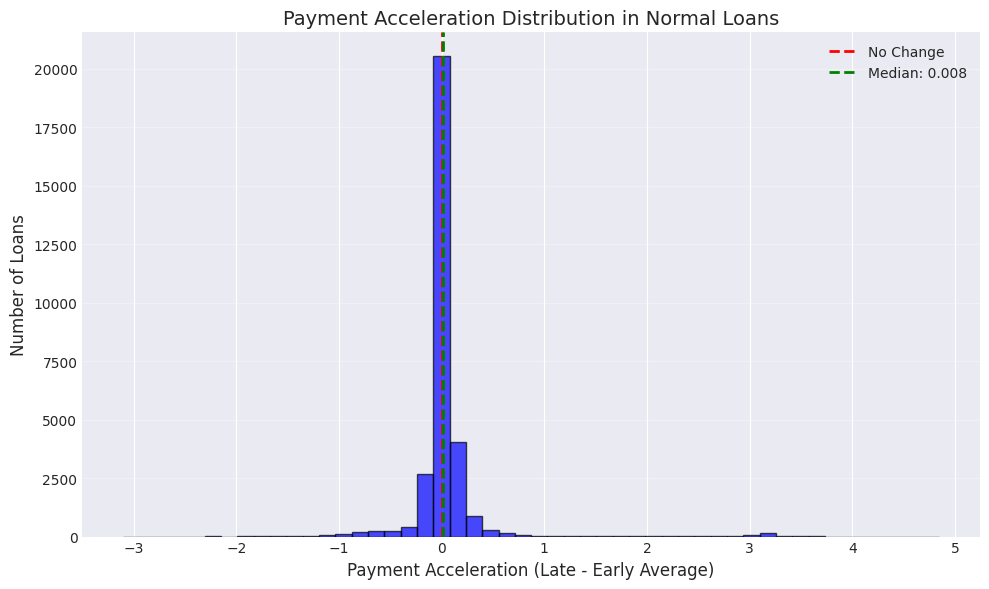

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(train_df['payment_acceleration'].dropna(), bins=50, color='blue', alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Change')
median_accel = train_df['payment_acceleration'].median()
ax.axvline(x=median_accel, color='green', linestyle='--', linewidth=2, label=f"Median: {median_accel:.3f}")
ax.set_xlabel('Payment Acceleration (Late - Early Average)', fontsize=12)
ax.set_ylabel('Number of Loans', fontsize=12)
ax.set_title('Payment Acceleration Distribution in Normal Loans', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

- Nearly all loans have acceleration ≈ 0 (median = 0.008, very close to zero)
- This means most normal loans maintain consistent payment patterns, they don't improve or worsen significantly over time

##### 3. Indepth EDA: Normal Loan Balance Trajectory 

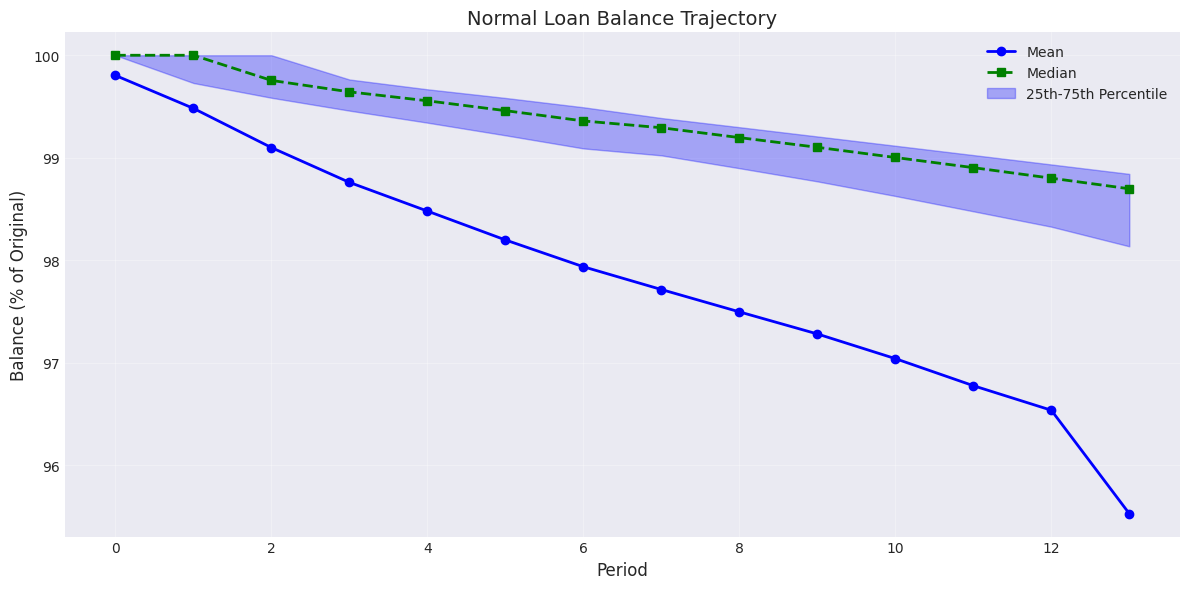

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
means = []
medians = []
q25 = []
q75 = []
for period in range(0, 14):
    col = f"{period}_CurrentActualUPB"
    pct_of_original = (train_df[col] / train_df['OriginalUPB'] * 100)
    means.append(pct_of_original.mean())
    medians.append(pct_of_original.median())
    q25.append(pct_of_original.quantile(0.25))
    q75.append(pct_of_original.quantile(0.75))

periods = list(range(0, 14))
ax.plot(periods, means, marker='o', label='Mean', color='blue', linewidth=2)
ax.plot(periods, medians, marker='s', label='Median', color='green', linewidth=2, linestyle='--')
ax.fill_between(periods, q25, q75, alpha=0.3, color='blue', label='25th-75th Percentile')
ax.set_xlabel('Period', fontsize=12)
ax.set_ylabel('Balance (% of Original)', fontsize=12)
ax.set_title('Normal Loan Balance Trajectory', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

- Mean balance drops from 100% to only 95.5% over 13 months (~0.35% per month)
- Median is even higher at 98.7% - most loans barely pay down principal
- This means loans are paying far less than scheduled, mostly covering interest with minimal principal reduction



##### 4. Indepth EDA: Advanced Payment Patterns - Statistical Analysis

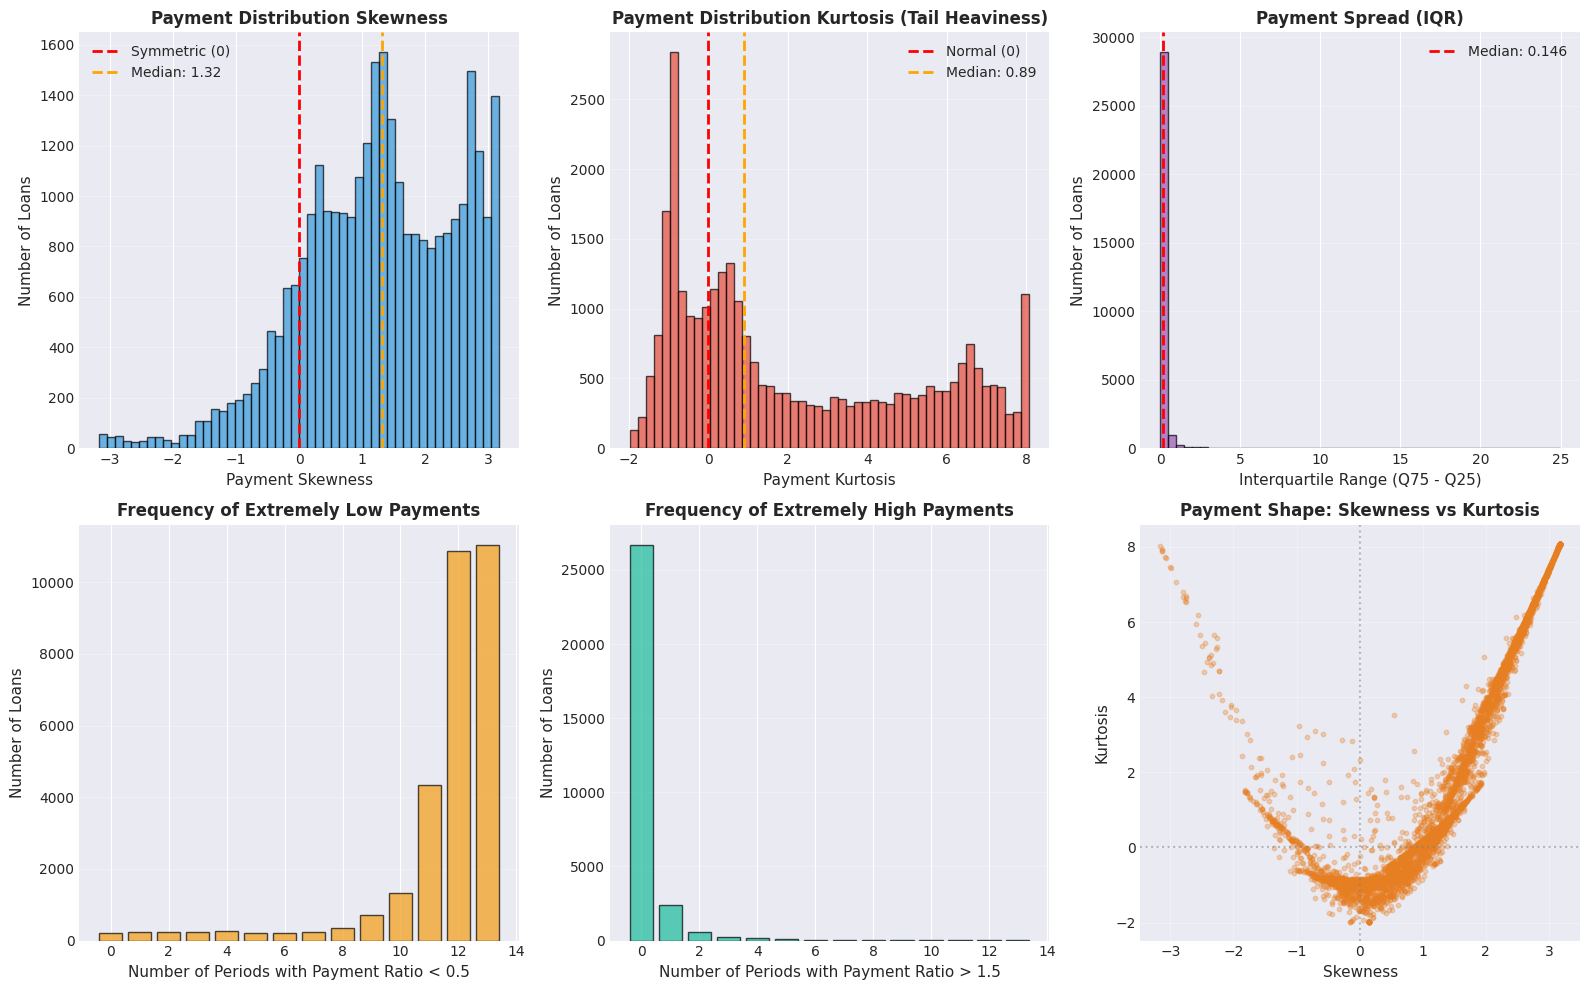


Advanced Pattern Statistics:
Loans with positive skew (right-tailed): 26168 (85.8%)
Loans with high kurtosis (heavy tails, >3): 10886 (35.7%)
Loans with extreme low payments (ratio < 0.5): 30303 (99.3%)
Loans with extreme high payments (ratio > 1.5): 3799 (12.5%)


In [ ]:
def calculate_monthly_payment(principal, annual_rate, term_months):
    """Calculate scheduled monthly payment for a loan"""
    monthly_rate = annual_rate / 100 / 12
    if monthly_rate == 0:
        return principal / term_months
    return principal * monthly_rate * (1 + monthly_rate) ** term_months / ((1 + monthly_rate) ** term_months - 1)

payment_ratios = []
scheduled_payment = train_df.apply(
    lambda x: calculate_monthly_payment(
        x['OriginalUPB'], 
        x['OriginalInterestRate'], 
        x['OriginalLoanTerm']
    ), 
    axis=1
)

for period in range(1, 14):
    actual_payment = train_df[f"{period-1}_CurrentActualUPB"] - train_df[f"{period}_CurrentActualUPB"]
    actual_payment = actual_payment.clip(lower=0)
    ratio = actual_payment / scheduled_payment.replace(0, np.nan)
    payment_ratios.append(ratio)

payment_ratio_array = np.array(payment_ratios).T

train_df['payment_skewness'] = stats.skew(payment_ratio_array, axis=1, nan_policy='omit')
train_df['payment_kurtosis'] = stats.kurtosis(payment_ratio_array, axis=1, nan_policy='omit')
train_df['payment_q25'] = np.percentile(payment_ratio_array, 25, axis=1)
train_df['payment_q75'] = np.percentile(payment_ratio_array, 75, axis=1)
train_df['payment_iqr'] = train_df['payment_q75'] - train_df['payment_q25']
train_df['extreme_low_payments'] = (payment_ratio_array < 0.5).sum(axis=1)
train_df['extreme_high_payments'] = (payment_ratio_array > 1.5).sum(axis=1)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Skewness Distribution
ax1 = axes[0, 0]
skew_clean = train_df['payment_skewness'].replace([np.inf, -np.inf], np.nan).dropna()
ax1.hist(skew_clean, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Symmetric (0)')
ax1.axvline(skew_clean.median(), color='orange', linestyle='--', linewidth=2, 
            label=f"Median: {skew_clean.median():.2f}")
ax1.set_xlabel('Payment Skewness', fontsize=11)
ax1.set_ylabel('Number of Loans', fontsize=11)
ax1.set_title('Payment Distribution Skewness', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Kurtosis Distribution
ax2 = axes[0, 1]
kurt_clean = train_df['payment_kurtosis'].replace([np.inf, -np.inf], np.nan).dropna()
ax2.hist(kurt_clean, bins=50, color='#e74c3c', edgecolor='black', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='Normal (0)')
ax2.axvline(kurt_clean.median(), color='orange', linestyle='--', linewidth=2, 
            label=f"Median: {kurt_clean.median():.2f}")
ax2.set_xlabel('Payment Kurtosis', fontsize=11)
ax2.set_ylabel('Number of Loans', fontsize=11)
ax2.set_title('Payment Distribution Kurtosis (Tail Heaviness)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Interquartile Range
ax3 = axes[0, 2]
ax3.hist(train_df['payment_iqr'], bins=50, color='#9b59b6', edgecolor='black', alpha=0.7)
ax3.axvline(train_df['payment_iqr'].median(), color='red', linestyle='--', linewidth=2, 
            label=f"Median: {train_df['payment_iqr'].median():.3f}")
ax3.set_xlabel('Interquartile Range (Q75 - Q25)', fontsize=11)
ax3.set_ylabel('Number of Loans', fontsize=11)
ax3.set_title('Payment Spread (IQR)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Extreme Low Payments
ax4 = axes[1, 0]
extreme_low_counts = train_df['extreme_low_payments'].value_counts().sort_index()
ax4.bar(extreme_low_counts.index, extreme_low_counts.values, color='#f39c12', edgecolor='black', alpha=0.7)
ax4.set_xlabel('Number of Periods with Payment Ratio < 0.5', fontsize=11)
ax4.set_ylabel('Number of Loans', fontsize=11)
ax4.set_title('Frequency of Extremely Low Payments', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Extreme High Payments
ax5 = axes[1, 1]
extreme_high_counts = train_df['extreme_high_payments'].value_counts().sort_index()
ax5.bar(extreme_high_counts.index, extreme_high_counts.values, color='#1abc9c', edgecolor='black', alpha=0.7)
ax5.set_xlabel('Number of Periods with Payment Ratio > 1.5', fontsize=11)
ax5.set_ylabel('Number of Loans', fontsize=11)
ax5.set_title('Frequency of Extremely High Payments', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# Skewness vs Kurtosis Scatter
ax6 = axes[1, 2]
sample_idx = np.random.choice(len(train_df), size=min(5000, len(train_df)), replace=False)
scatter_data = train_df.iloc[sample_idx][['payment_skewness', 'payment_kurtosis']].replace([np.inf, -np.inf], np.nan).dropna()
ax6.scatter(scatter_data['payment_skewness'], scatter_data['payment_kurtosis'], 
            alpha=0.3, s=10, color='#e67e22')
ax6.axhline(0, color='gray', linestyle=':', alpha=0.5)
ax6.axvline(0, color='gray', linestyle=':', alpha=0.5)
ax6.set_xlabel('Skewness', fontsize=11)
ax6.set_ylabel('Kurtosis', fontsize=11)
ax6.set_title('Payment Shape: Skewness vs Kurtosis', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAdvanced Pattern Statistics:")
print(f"Loans with positive skew (right-tailed): {(train_df['payment_skewness'] > 0).sum()} "
      f"({(train_df['payment_skewness'] > 0).sum()/len(train_df)*100:.1f}%)")
print(f"Loans with high kurtosis (heavy tails, >3): {(train_df['payment_kurtosis'] > 3).sum()} "
      f"({(train_df['payment_kurtosis'] > 3).sum()/len(train_df)*100:.1f}%)")
print(f"Loans with extreme low payments (ratio < 0.5): {(train_df['extreme_low_payments'] > 0).sum()} "
      f"({(train_df['extreme_low_payments'] > 0).sum()/len(train_df)*100:.1f}%)")
print(f"Loans with extreme high payments (ratio > 1.5): {(train_df['extreme_high_payments'] > 0).sum()} "
      f"({(train_df['extreme_high_payments'] > 0).sum()/len(train_df)*100:.1f}%)")

**Kurtosis Distribution**:
- 35.7% have kurtosis >3 (high volatility)
- ~1,100 loans at kurtosis ~8 (extreme volatility but still performing)
- Bimodal distribution shows clear split within normal loans

**Extreme Payment Frequencies**:
- 99.3% of normal loans underpay severely (ratio <0.5) in 12-13 months
- Implication: underpayment amount is irrelevant; payment pattern matters

**Skewness vs Kurtosis (V-shaped Boundary)**:
- V-shape defines "normal" portfolio behavior
- Bottom-left: stable underpayers | Upper-right: volatile performers
- Anomalies: outside V-pattern (flatlined/abandoned or chaotic)

##### 5. Indepth EDA: Balance Trajectory - Trend and Volatility Analysis

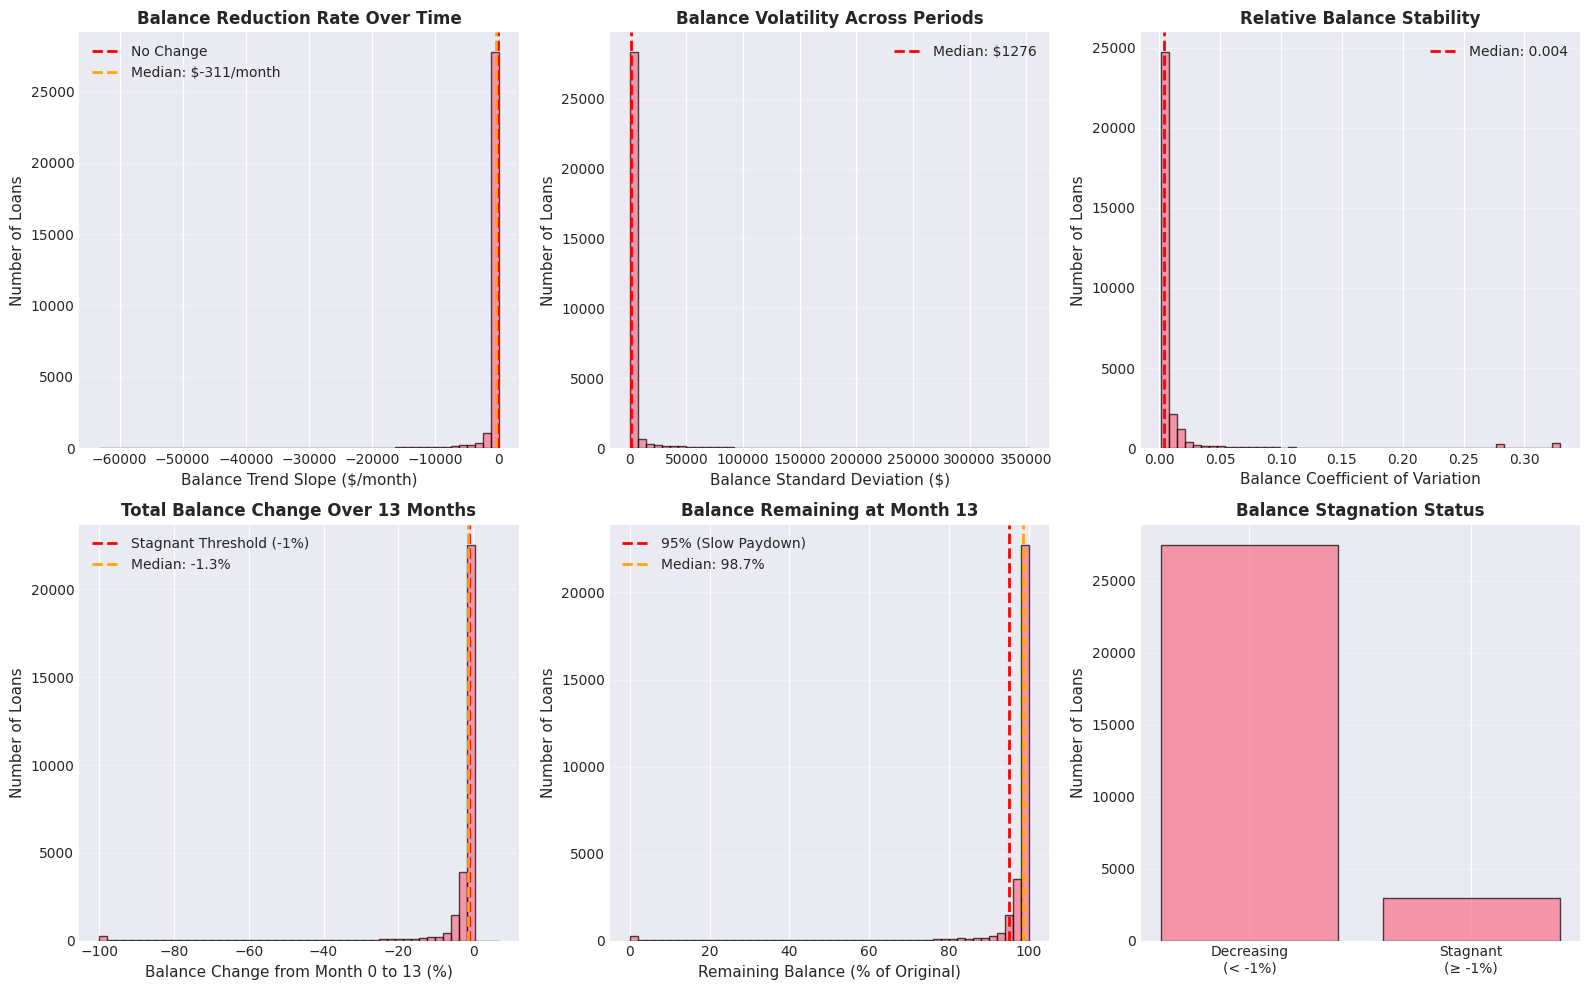


Balance Trajectory Statistics:
Median balance reduction rate: $-311.48 per month
Loans with negative slope (increasing balance): 11 (0.0%)
Loans with stagnant balance: 2990 (9.8%)
Median remaining balance: 98.7% of original


In [ ]:
balances = []
for period in range(0, 14):
    balances.append(train_df[f"{period}_CurrentActualUPB"])
balance_array = np.array(balances).T

time_points = np.arange(14)
slopes = []
intercepts = []
for idx in range(len(train_df)):
    slope, intercept = np.polyfit(time_points, balance_array[idx], 1)
    slopes.append(slope)
    intercepts.append(intercept)

train_df['balance_trend_slope'] = slopes
train_df['balance_trend_intercept'] = intercepts
train_df['balance_std'] = np.std(balance_array, axis=1)
train_df['balance_cv'] = train_df['balance_std'] / np.mean(balance_array, axis=1)
train_df['balance_pct_change'] = (train_df['13_CurrentActualUPB'] - train_df['0_CurrentActualUPB']) / train_df['0_CurrentActualUPB'].replace(0, np.nan)
train_df['balance_stagnant'] = (train_df['balance_pct_change'] > -0.01).astype(int)
train_df['remaining_balance_ratio'] = train_df['13_CurrentActualUPB'] / train_df['OriginalUPB']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Balance Trend Slope
ax1 = axes[0, 0]
ax1.hist(train_df['balance_trend_slope'], bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='No Change')
ax1.axvline(train_df['balance_trend_slope'].median(), color='orange', linestyle='--', 
            linewidth=2, label=f"Median: ${train_df['balance_trend_slope'].median():.0f}/month")
ax1.set_xlabel('Balance Trend Slope ($/month)', fontsize=11)
ax1.set_ylabel('Number of Loans', fontsize=11)
ax1.set_title('Balance Reduction Rate Over Time', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Balance Volatility
ax2 = axes[0, 1]
ax2.hist(train_df['balance_std'], bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(train_df['balance_std'].median(), color='red', linestyle='--', 
            linewidth=2, label=f"Median: ${train_df['balance_std'].median():.0f}")
ax2.set_xlabel('Balance Standard Deviation ($)', fontsize=11)
ax2.set_ylabel('Number of Loans', fontsize=11)
ax2.set_title('Balance Volatility Across Periods', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Coefficient of Variation
ax3 = axes[0, 2]
cv_clean = train_df['balance_cv'].replace([np.inf, -np.inf], np.nan).dropna()
cv_clipped = cv_clean.clip(upper=cv_clean.quantile(0.99))
ax3.hist(cv_clipped, bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(cv_clipped.median(), color='red', linestyle='--', 
            linewidth=2, label=f"Median: {cv_clipped.median():.3f}")
ax3.set_xlabel('Balance Coefficient of Variation', fontsize=11)
ax3.set_ylabel('Number of Loans', fontsize=11)
ax3.set_title('Relative Balance Stability', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Balance Percent Change
ax4 = axes[1, 0]
pct_change_clean = train_df['balance_pct_change'].replace([np.inf, -np.inf], np.nan).dropna()
ax4.hist(pct_change_clean * 100, bins=50, edgecolor='black', alpha=0.7)
ax4.axvline(-1, color='red', linestyle='--', linewidth=2, label='Stagnant Threshold (-1%)')
ax4.axvline(pct_change_clean.median() * 100, color='orange', linestyle='--', 
            linewidth=2, label=f"Median: {pct_change_clean.median()*100:.1f}%")
ax4.set_xlabel('Balance Change from Month 0 to 13 (%)', fontsize=11)
ax4.set_ylabel('Number of Loans', fontsize=11)
ax4.set_title('Total Balance Change Over 13 Months', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Remaining Balance Ratio
ax5 = axes[1, 1]
ax5.hist(train_df['remaining_balance_ratio'] * 100, bins=50, edgecolor='black', alpha=0.7)
ax5.axvline(95, color='red', linestyle='--', linewidth=2, label='95% (Slow Paydown)')
ax5.axvline(train_df['remaining_balance_ratio'].median() * 100, color='orange', linestyle='--', 
            linewidth=2, label=f"Median: {train_df['remaining_balance_ratio'].median()*100:.1f}%")
ax5.set_xlabel('Remaining Balance (% of Original)', fontsize=11)
ax5.set_ylabel('Number of Loans', fontsize=11)
ax5.set_title('Balance Remaining at Month 13', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# Stagnant Balance Distribution
ax6 = axes[1, 2]
stagnant_counts = train_df['balance_stagnant'].value_counts()
labels = ['Decreasing\n(< -1%)', 'Stagnant\n(≥ -1%)']
ax6.bar(labels, [stagnant_counts.get(0, 0), stagnant_counts.get(1, 0)], 
        edgecolor='black', alpha=0.7)
ax6.set_ylabel('Number of Loans', fontsize=11)
ax6.set_title('Balance Stagnation Status', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nBalance Trajectory Statistics:")
print(f"Median balance reduction rate: ${train_df['balance_trend_slope'].median():.2f} per month")
print(f"Loans with negative slope (increasing balance): {(train_df['balance_trend_slope'] > 0).sum()} "
      f"({(train_df['balance_trend_slope'] > 0).sum()/len(train_df)*100:.1f}%)")
print(f"Loans with stagnant balance: {train_df['balance_stagnant'].sum()} "
      f"({train_df['balance_stagnant'].sum()/len(train_df)*100:.1f}%)")
print(f"Median remaining balance: {train_df['remaining_balance_ratio'].median()*100:.1f}% of original")

**Slow Paydown Pattern**:
- Median reduction: $311/month on $300k+ mortgages (far below standard amortization)
- Extremely narrow distribution, everyone follows same pattern

**Minimal Variation (CV = 0.004)**:
- Balances vary <0.5% across 13 months
- Indicates systematic modification/forbearance, not normal mortgage behavior

**Total Principal Reduction**:
- Median -1.3% over 13 months with tight clustering

**Stagnant Loans**:
- 9% (2,990 loans) nearly stagnant (≥-1% change) but still labeled normal
- Likely riskiest subset of performing loans

##### 6. Indepth EDA: Credit Risk Indicators (Combined with Payment Behavior)

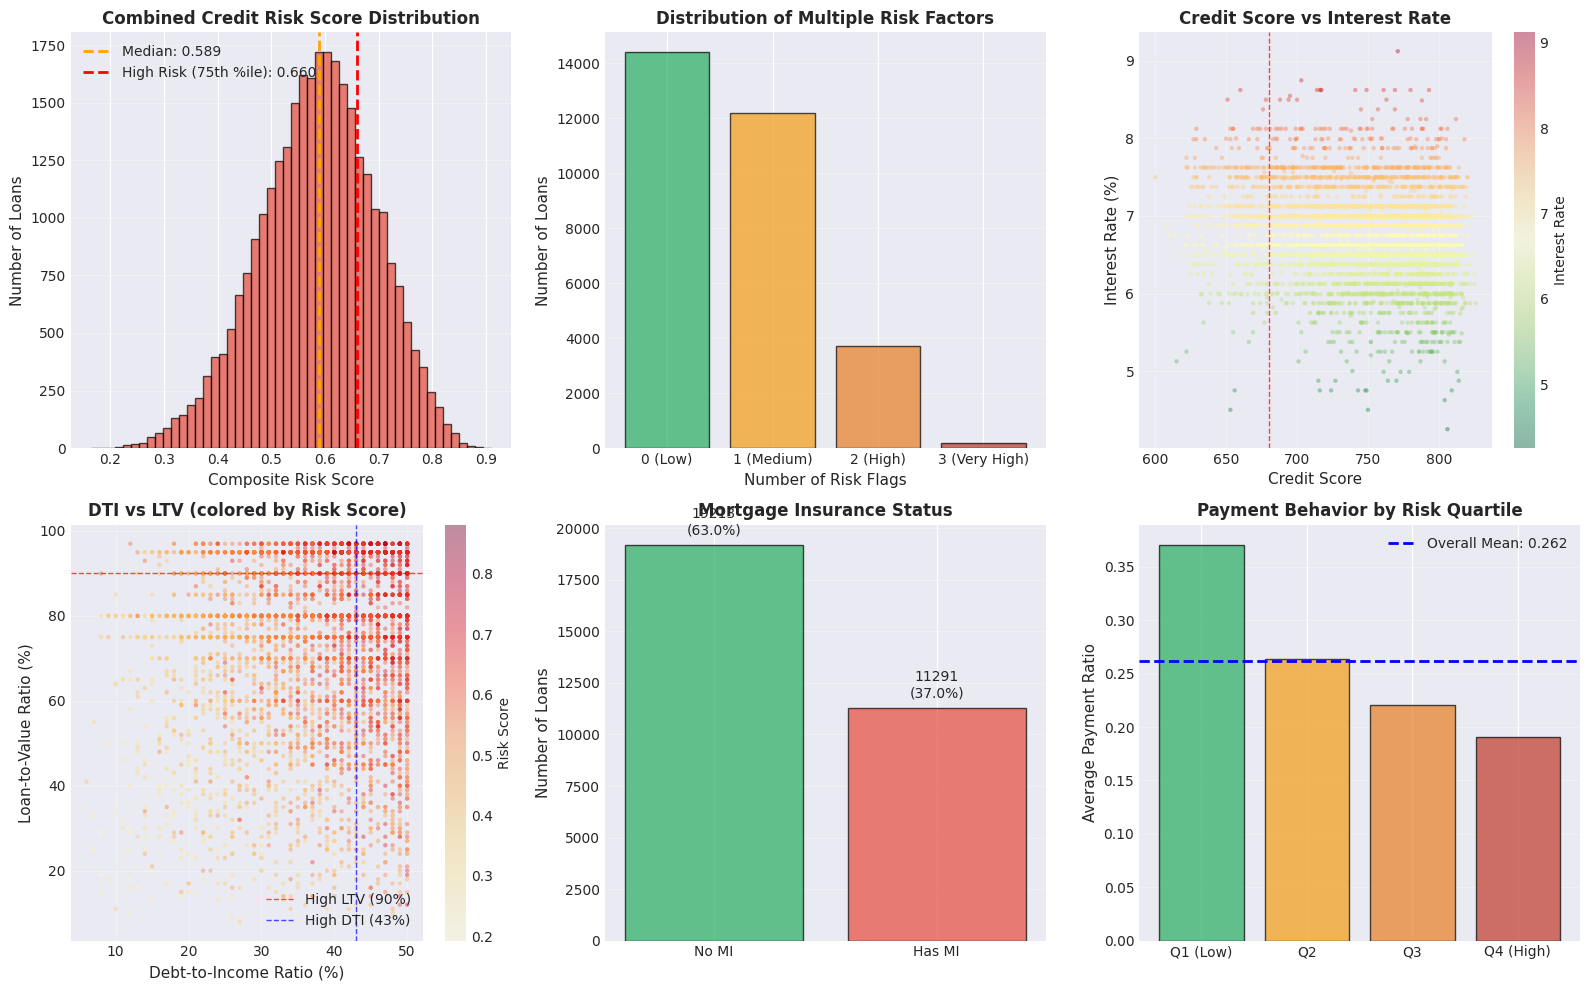


Credit Risk Statistics:
Loans with 0 risk flags: 14405 (47.2%)
Loans with 1+ risk flags: 16099 (52.8%)
Loans with 2+ risk flags: 3918 (12.8%)
Loans with 3 risk flags: 197 (0.6%)

Median composite risk score: 0.589
High risk loans (top 25%): 7626


In [ ]:
ratio_cols = []
scheduled_payment = train_df.apply(
    lambda x: calculate_monthly_payment(
        x['OriginalUPB'], 
        x['OriginalInterestRate'], 
        x['OriginalLoanTerm']
    ), 
    axis=1
)

for period in range(1, 14):
    current_upb_col = f"{period}_CurrentActualUPB"
    prev_upb_col = f"{period-1}_CurrentActualUPB"
    
    actual_payment = train_df[prev_upb_col] - train_df[current_upb_col]
    actual_payment = actual_payment.clip(lower=0)
    
    ratio = actual_payment / scheduled_payment.replace(0, np.nan)
    upper_bound = ratio.quantile(0.99)
    ratio = ratio.clip(upper=upper_bound)
    train_df[f"ratio_{period}"] = ratio

ratio_cols = [f'ratio_{i}' for i in range(1, 14)]
train_df['avg_ratio'] = train_df[ratio_cols].mean(axis=1)

train_df['credit_score_clean'] = train_df['CreditScore'].replace(9999, np.nan)
train_df['dti_clean'] = train_df['OriginalDTI'].replace(999, np.nan)
train_df['ltv_clean'] = train_df['OriginalLTV'].replace(999, np.nan)
train_df['cltv_clean'] = train_df['OriginalCLTV'].replace(999, np.nan)

# Calculate composite risk score
train_df['composite_risk_score'] = (
    (800 - train_df['credit_score_clean'].fillna(750)) / 200 * 0.3 +
    train_df['dti_clean'].fillna(37) / 50 * 0.3 +
    train_df['ltv_clean'].fillna(75) / 100 * 0.2 +
    train_df['OriginalInterestRate'] / 10 * 0.2
)

# Risk flags
train_df['high_dti_flag'] = (train_df['dti_clean'] > 43).astype(int)
train_df['high_ltv_flag'] = (train_df['ltv_clean'] > 90).astype(int)
train_df['low_credit_flag'] = (train_df['credit_score_clean'] < 680).astype(int)
train_df['has_mi_flag'] = (train_df['MI_Pct'] > 0).astype(int)

# Combined risk categories
train_df['total_risk_flags'] = (train_df['high_dti_flag'] + train_df['high_ltv_flag'] + 
                                 train_df['low_credit_flag'])

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Composite Risk Score
ax1 = axes[0, 0]
ax1.hist(train_df['composite_risk_score'], bins=50, color='#e74c3c', edgecolor='black', alpha=0.7)
ax1.axvline(train_df['composite_risk_score'].median(), color='orange', linestyle='--', 
            linewidth=2, label=f"Median: {train_df['composite_risk_score'].median():.3f}")
high_risk_threshold = train_df['composite_risk_score'].quantile(0.75)
ax1.axvline(high_risk_threshold, color='red', linestyle='--', linewidth=2, 
            label=f"High Risk (75th %ile): {high_risk_threshold:.3f}")
ax1.set_xlabel('Composite Risk Score', fontsize=11)
ax1.set_ylabel('Number of Loans', fontsize=11)
ax1.set_title('Combined Credit Risk Score Distribution', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Risk Flag Combinations
ax2 = axes[0, 1]
risk_flag_counts = train_df['total_risk_flags'].value_counts().sort_index()
colors_risk = ['#27ae60', '#f39c12', '#e67e22', '#c0392b']
ax2.bar(risk_flag_counts.index, risk_flag_counts.values, 
        color=[colors_risk[i] for i in risk_flag_counts.index], edgecolor='black', alpha=0.7)
ax2.set_xlabel('Number of Risk Flags', fontsize=11)
ax2.set_ylabel('Number of Loans', fontsize=11)
ax2.set_title('Distribution of Multiple Risk Factors', fontsize=12, fontweight='bold')
ax2.set_xticks(range(4))
ax2.set_xticklabels(['0 (Low)', '1 (Medium)', '2 (High)', '3 (Very High)'])
ax2.grid(True, alpha=0.3, axis='y')

# Credit Score vs Interest Rate
ax3 = axes[0, 2]
sample_idx = np.random.choice(len(train_df), size=min(5000, len(train_df)), replace=False)
scatter_data = train_df.iloc[sample_idx][['credit_score_clean', 'OriginalInterestRate']].dropna()
scatter = ax3.scatter(scatter_data['credit_score_clean'], scatter_data['OriginalInterestRate'], 
                      c=scatter_data['OriginalInterestRate'], cmap='RdYlGn_r', 
                      alpha=0.4, s=10, edgecolors='none')
ax3.axvline(680, color='red', linestyle='--', linewidth=1, alpha=0.7)
ax3.set_xlabel('Credit Score', fontsize=11)
ax3.set_ylabel('Interest Rate (%)', fontsize=11)
ax3.set_title('Credit Score vs Interest Rate', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax3, label='Interest Rate')
ax3.grid(True, alpha=0.3)

# DTI vs LTV Scatter
ax4 = axes[1, 0]
scatter_data2 = train_df.iloc[sample_idx][['dti_clean', 'ltv_clean', 'composite_risk_score']].dropna()
scatter2 = ax4.scatter(scatter_data2['dti_clean'], scatter_data2['ltv_clean'], 
                       c=scatter_data2['composite_risk_score'], cmap='YlOrRd', 
                       alpha=0.4, s=10, edgecolors='none')
ax4.axhline(90, color='red', linestyle='--', linewidth=1, alpha=0.7, label='High LTV (90%)')
ax4.axvline(43, color='blue', linestyle='--', linewidth=1, alpha=0.7, label='High DTI (43%)')
ax4.set_xlabel('Debt-to-Income Ratio (%)', fontsize=11)
ax4.set_ylabel('Loan-to-Value Ratio (%)', fontsize=11)
ax4.set_title('DTI vs LTV (colored by Risk Score)', fontsize=12, fontweight='bold')
plt.colorbar(scatter2, ax=ax4, label='Risk Score')
ax4.legend(loc='lower right')
ax4.grid(True, alpha=0.3)

# Mortgage Insurance Distribution
ax5 = axes[1, 1]
mi_categories = []
for val in train_df['MI_Pct']:
    if val == 0:
        mi_categories.append('No MI')
    elif val == 999:
        mi_categories.append('Unknown')
    else:
        mi_categories.append('Has MI')
mi_dist = pd.Series(mi_categories).value_counts()
colors_mi = ['#27ae60', '#e74c3c', '#95a5a6']
ax5.bar(mi_dist.index, mi_dist.values, color=colors_mi, edgecolor='black', alpha=0.7)
for i, v in enumerate(mi_dist.values):
    ax5.text(i, v + 500, f"{v}\n({v/len(train_df)*100:.1f}%)", ha='center', fontsize=10)
ax5.set_ylabel('Number of Loans', fontsize=11)
ax5.set_title('Mortgage Insurance Status', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# Risk Score by Payment Behavior
ax6 = axes[1, 2]
risk_quartiles = pd.qcut(train_df['composite_risk_score'], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
payment_by_risk = train_df.groupby(risk_quartiles)['avg_ratio'].mean()
colors_q = ['#27ae60', '#f39c12', '#e67e22', '#c0392b']
bars = ax6.bar(range(len(payment_by_risk)), payment_by_risk.values, 
               color=colors_q, edgecolor='black', alpha=0.7)
ax6.set_xticks(range(len(payment_by_risk)))
ax6.set_xticklabels(payment_by_risk.index, rotation=0)
ax6.set_ylabel('Average Payment Ratio', fontsize=11)
ax6.set_title('Payment Behavior by Risk Quartile', fontsize=12, fontweight='bold')
ax6.axhline(train_df['avg_ratio'].mean(), color='blue', linestyle='--', 
            linewidth=2, label=f"Overall Mean: {train_df['avg_ratio'].mean():.3f}")
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nCredit Risk Statistics:")
print(f"Loans with 0 risk flags: {(train_df['total_risk_flags'] == 0).sum()} "
      f"({(train_df['total_risk_flags'] == 0).sum()/len(train_df)*100:.1f}%)")
print(f"Loans with 1+ risk flags: {(train_df['total_risk_flags'] >= 1).sum()} "
      f"({(train_df['total_risk_flags'] >= 1).sum()/len(train_df)*100:.1f}%)")
print(f"Loans with 2+ risk flags: {(train_df['total_risk_flags'] >= 2).sum()} "
      f"({(train_df['total_risk_flags'] >= 2).sum()/len(train_df)*100:.1f}%)")
print(f"Loans with 3 risk flags: {(train_df['total_risk_flags'] == 3).sum()} "
      f"({(train_df['total_risk_flags'] == 3).sum()/len(train_df)*100:.1f}%)")
print(f"\nMedian composite risk score: {train_df['composite_risk_score'].median():.3f}")
print(f"High risk loans (top 25%): {(train_df['composite_risk_score'] > train_df['composite_risk_score'].quantile(0.75)).sum()}")

**Risk Flag Distribution**:
- 52.8% have 1+ traditional risk flags (high DTI/LTV, low credit) but still performing
- Only 197 loans (0.6%) have all 3 flags, yet still normal
- Static origination risk might not predictive alone

**DTI vs LTV Analysis**:
- Dense clustering in high-risk quadrant (high DTI + high LTV) still labeled normal
- Traditional underwriting flags don't separate anomalies

**Payment by Risk Quartile**:
- All quartiles pay similarly (0.19-0.36 ratio)
- Q4 (highest traditional risk) pays only marginally less than Q1

### Feature Engineering Strategy

**Feature Groups**
1. **baseline_payment**: Payment ratios (actual/scheduled) with 3-period rolling stats (mean, std, trends)
2. **payment_velocity**: Principal reduction rates, early vs late acceleration
3. **payment_irregularity**: Underpayment/zero payment flags, counts, streaks (instability signals)
4. **balance_trajectory**: Linear trend slope, volatility (std/CV), stagnation detection
5. **credit_risk**: Traditional origination metrics (credit score, DTI, LTV, rate)
6. **temporal_changes**: Early (1-6) vs late (7-13) period comparison, behavioral shifts
7. **advanced_patterns**: Distribution stats (skewness, kurtosis, IQR) capturing V-shaped boundary

In [ ]:
def create_baseline_payment_features(df):
    """Payment ratios and windowed statistics"""
    features = pd.DataFrame(index=df.index)
    scheduled_payment = df.apply(
        lambda x: calculate_monthly_payment(x['OriginalUPB'], x['OriginalInterestRate'], x['OriginalLoanTerm']), 
        axis=1
    )
    
    for period in range(1, 14):
        actual_payment = df[f"{period-1}_CurrentActualUPB"] - df[f"{period}_CurrentActualUPB"]
        actual_payment = actual_payment.clip(lower=0)
        ratio = (actual_payment / scheduled_payment.replace(0, np.nan)).clip(upper=actual_payment.quantile(0.99) / scheduled_payment.replace(0, np.nan).quantile(0.99))
        features[f"payment_ratio_{period}"] = ratio
    
    # Windowed stats
    for i in range(3, 14):
        features[f"ratio_mean_win3_{i}"] = features[[f"payment_ratio_{i-2}", f"payment_ratio_{i-1}", f"payment_ratio_{i}"]].mean(axis=1)
        features[f"ratio_std_win3_{i}"] = features[[f"payment_ratio_{i-2}", f"payment_ratio_{i-1}", f"payment_ratio_{i}"]].std(axis=1)
    
    ratio_cols = [col for col in features.columns if col.startswith('payment_ratio_')]
    features['avg_payment_ratio'] = features[ratio_cols].mean(axis=1)
    features['std_payment_ratio'] = features[ratio_cols].std(axis=1)
    features['under_payment_count'] = (features[ratio_cols] < 1.0).sum(axis=1)
    features['zero_payment_count'] = (features[ratio_cols] == 0).sum(axis=1)
    
    early_avg = features[[f"payment_ratio_{i}" for i in range(1, 7)]].mean(axis=1)
    late_avg = features[[f"payment_ratio_{i}" for i in range(7, 14)]].mean(axis=1)
    features['payment_acceleration'] = late_avg - early_avg
    
    return features

def create_payment_velocity_features(df):
    """Principal reduction rates and trends"""
    features = pd.DataFrame(index=df.index)
    
    for period in range(1, 14):
        features[f"principal_reduction_{period}"] = df[f"{period-1}_CurrentActualUPB"] - df[f"{period}_CurrentActualUPB"]
    
    reduction_cols = [col for col in features.columns if col.startswith('principal_reduction_')]
    features['avg_principal_reduction'] = features[reduction_cols].mean(axis=1)
    features['std_principal_reduction'] = features[reduction_cols].std(axis=1)
    
    return features

def create_payment_irregularity_features(df):
    """Underpayment flags and streak detection"""
    features = pd.DataFrame(index=df.index)
    scheduled_payment = df.apply(
        lambda x: calculate_monthly_payment(x['OriginalUPB'], x['OriginalInterestRate'], x['OriginalLoanTerm']), 
        axis=1
    )
    
    for period in range(1, 14):
        actual_payment = (df[f"{period-1}_CurrentActualUPB"] - df[f"{period}_CurrentActualUPB"]).clip(lower=0)
        ratio = actual_payment / scheduled_payment.replace(0, np.nan)
        features[f"underpayment_{period}"] = (ratio < 0.9).astype(int)
        features[f"zero_payment_{period}"] = (actual_payment == 0).astype(int)
    
    underpayment_cols = [col for col in features.columns if col.startswith('underpayment_')]
    features['total_underpayments'] = features[underpayment_cols].sum(axis=1)
    features['recent_underpayments'] = features[[f"underpayment_{i}" for i in range(11, 14)]].sum(axis=1)
    
    # Max streak
    for idx in df.index:
        max_streak = current_streak = 0
        for col in underpayment_cols:
            if features.loc[idx, col] == 1:
                current_streak += 1
                max_streak = max(max_streak, current_streak)
            else:
                current_streak = 0
        features.loc[idx, 'max_underpayment_streak'] = max_streak
    
    return features

def create_balance_trajectory_features(df):
    """Balance evolution and stagnation metrics"""
    features = pd.DataFrame(index=df.index)
    balances = np.array([df[f"{period}_CurrentActualUPB"] for period in range(14)]).T
    time_points = np.arange(14)
    
    for idx in range(len(df)):
        slope, _ = np.polyfit(time_points, balances[idx], 1)
        features.loc[df.index[idx], 'balance_trend_slope'] = slope
    
    features['balance_std'] = np.std(balances, axis=1)
    features['balance_pct_change'] = (df['13_CurrentActualUPB'] - df['0_CurrentActualUPB']) / df['0_CurrentActualUPB'].replace(0, np.nan)
    features['balance_stagnant'] = (features['balance_pct_change'] > -0.01).astype(int)
    features['remaining_balance_ratio'] = df['13_CurrentActualUPB'] / df['OriginalUPB']
    
    return features

def create_credit_risk_features(df):
    """Traditional origination risk factors"""
    features = pd.DataFrame(index=df.index)
    features['credit_score'] = df['CreditScore']
    features['dti_ratio'] = df['OriginalDTI']
    features['ltv_ratio'] = df['OriginalLTV']
    features['interest_rate'] = df['OriginalInterestRate']
    
    features['risk_score'] = (
        (800 - df['CreditScore']) / 200 * 0.3 +
        df['OriginalDTI'] / 50 * 0.3 +
        df['OriginalLTV'] / 100 * 0.2 +
        df['OriginalInterestRate'] / 10 * 0.2
    )
    
    features['high_dti'] = (df['OriginalDTI'] > 43).astype(int)
    features['high_ltv'] = (df['OriginalLTV'] > 90).astype(int)
    features['low_credit'] = (df['CreditScore'] < 680).astype(int)
    
    return features

def create_temporal_change_features(df):
    """Behavioral shifts over time (early vs late)"""
    features = pd.DataFrame(index=df.index)
    scheduled_payment = df.apply(
        lambda x: calculate_monthly_payment(x['OriginalUPB'], x['OriginalInterestRate'], x['OriginalLoanTerm']), 
        axis=1
    )
    
    payment_ratios = []
    for period in range(1, 14):
        actual_payment = (df[f"{period-1}_CurrentActualUPB"] - df[f"{period}_CurrentActualUPB"]).clip(lower=0)
        payment_ratios.append(actual_payment / scheduled_payment.replace(0, np.nan))
    
    payment_ratio_array = np.array(payment_ratios).T
    early_avg = np.mean(payment_ratio_array[:, 0:6], axis=1)
    late_avg = np.mean(payment_ratio_array[:, 6:13], axis=1)
    
    features['early_payment_avg'] = early_avg
    features['late_payment_avg'] = late_avg
    features['payment_deterioration'] = early_avg - late_avg
    features['volatility_increase'] = np.std(payment_ratio_array[:, 6:13], axis=1) - np.std(payment_ratio_array[:, 0:6], axis=1)
    
    return features

def create_advanced_pattern_features(df):
    """Statistical distribution signatures"""
    features = pd.DataFrame(index=df.index)
    scheduled_payment = df.apply(
        lambda x: calculate_monthly_payment(x['OriginalUPB'], x['OriginalInterestRate'], x['OriginalLoanTerm']), 
        axis=1
    )
    
    payment_ratios = []
    for period in range(1, 14):
        actual_payment = (df[f"{period-1}_CurrentActualUPB"] - df[f"{period}_CurrentActualUPB"]).clip(lower=0)
        payment_ratios.append(actual_payment / scheduled_payment.replace(0, np.nan))
    
    payment_ratio_array = np.array(payment_ratios).T
    features['payment_skewness'] = stats.skew(payment_ratio_array, axis=1)
    features['payment_kurtosis'] = stats.kurtosis(payment_ratio_array, axis=1)
    features['payment_iqr'] = np.percentile(payment_ratio_array, 75, axis=1) - np.percentile(payment_ratio_array, 25, axis=1)
    features['extreme_low_payments'] = (payment_ratio_array < 0.5).sum(axis=1)
    features['extreme_high_payments'] = (payment_ratio_array > 1.5).sum(axis=1)
    
    return features

def build_and_scale_features(df, feature_groups, is_train=True):
    """Build features and apply preprocessing pipeline"""
    all_features = pd.DataFrame(index=df.index)
    
    for group_name, group_func in feature_groups:
        all_features = pd.concat([all_features, group_func(df)], axis=1)
    
    numeric_cols = all_features.select_dtypes(include=np.number).columns
    
    if is_train:
        # Outlier clipping
        bounds = {col: {'upper': all_features[col].quantile(0.995), 'lower': all_features[col].quantile(0.005)} 
                  for col in numeric_cols if all_features[col].notna().sum() > 0}
        globals()['_outlier_bounds'] = bounds
        
        for col in numeric_cols:
            if col in bounds:
                all_features[col] = all_features[col].clip(lower=bounds[col]['lower'], upper=bounds[col]['upper'])
        
        # Imputation
        imputer = SimpleImputer(strategy='median')
        all_features[numeric_cols] = imputer.fit_transform(all_features[numeric_cols])
        globals()['_imputer'] = imputer
        
        # Scaling
        scaler = StandardScaler()
        all_features_scaled = pd.DataFrame(
            scaler.fit_transform(all_features),
            columns=all_features.columns,
            index=all_features.index
        )
        globals()['_scaler'] = scaler
    else:
        # Apply fitted transformations
        if '_outlier_bounds' in globals():
            bounds = globals()['_outlier_bounds']
            for col in numeric_cols:
                if col in bounds:
                    all_features[col] = all_features[col].clip(lower=bounds[col]['lower'], upper=bounds[col]['upper'])
        
        if '_imputer' in globals():
            all_features[numeric_cols] = globals()['_imputer'].transform(all_features[numeric_cols])
        
        if '_scaler' in globals():
            all_features_scaled = pd.DataFrame(
                globals()['_scaler'].transform(all_features),
                columns=all_features.columns,
                index=all_features.index
            )
        else:
            all_features_scaled = all_features.copy()
    
    return all_features_scaled

# Define feature groups
feature_groups = {
    'baseline_payment': create_baseline_payment_features,
    'payment_velocity': create_payment_velocity_features,
    'payment_irregularity': create_payment_irregularity_features,
    'balance_trajectory': create_balance_trajectory_features,
    'credit_risk': create_credit_risk_features,
    'temporal_changes': create_temporal_change_features,
    'advanced_patterns': create_advanced_pattern_features,
}

print("\n" + "="*80)
print("FEATURE ENGINEERING COMPLETE")
print("="*80)
print(f"Available feature groups: {list(feature_groups.keys())}")


FEATURE ENGINEERING COMPLETE
Available feature groups: ['baseline_payment', 'payment_velocity', 'payment_irregularity', 'balance_trajectory', 'credit_risk', 'temporal_changes', 'advanced_patterns']


### Baseline Modeling

- Test each feature group individually with One-Class SVM (nu=0.04)
- Evaluate using Average Precision on validation set
- Rank groups by performance to identify best starting point


BASELINE MODELING: Maximizing Average Precision (AP)

Testing 7 feature groups...
Model: One-Class SVM (nu=0.04)
Metric: Average Precision (AP)

Training baseline_payment... 

AP = 0.164242 (40 features)
Training payment_velocity... AP = 0.159514 (15 features)
Training payment_irregularity... AP = 0.369800 (29 features)
Training balance_trajectory... AP = 0.189128 (5 features)
Training credit_risk... AP = 0.167926 (8 features)
Training temporal_changes... AP = 0.170530 (4 features)
Training advanced_patterns... AP = 0.148269 (5 features)

RESULTS: Ranked by Average Precision
               group  n_features  ap_score
payment_irregularity          29  0.369800
  balance_trajectory           5  0.189128
    temporal_changes           4  0.170530
         credit_risk           8  0.167926
    baseline_payment          40  0.164242
    payment_velocity          15  0.159514
   advanced_patterns           5  0.148269

BEST FEATURE GROUP
Winner: payment_irregularity
AP Score: 0.369800
Number of Features: 29
Improvement over Random: +193.5%

Generating Precision-Recall curves...


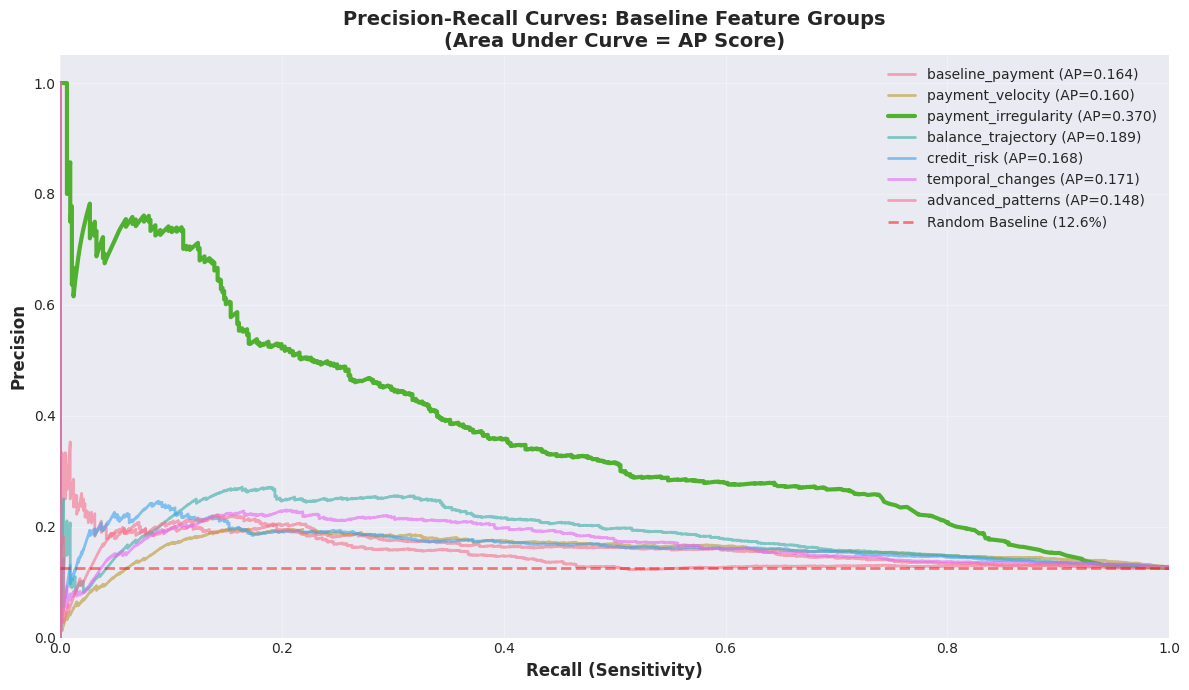

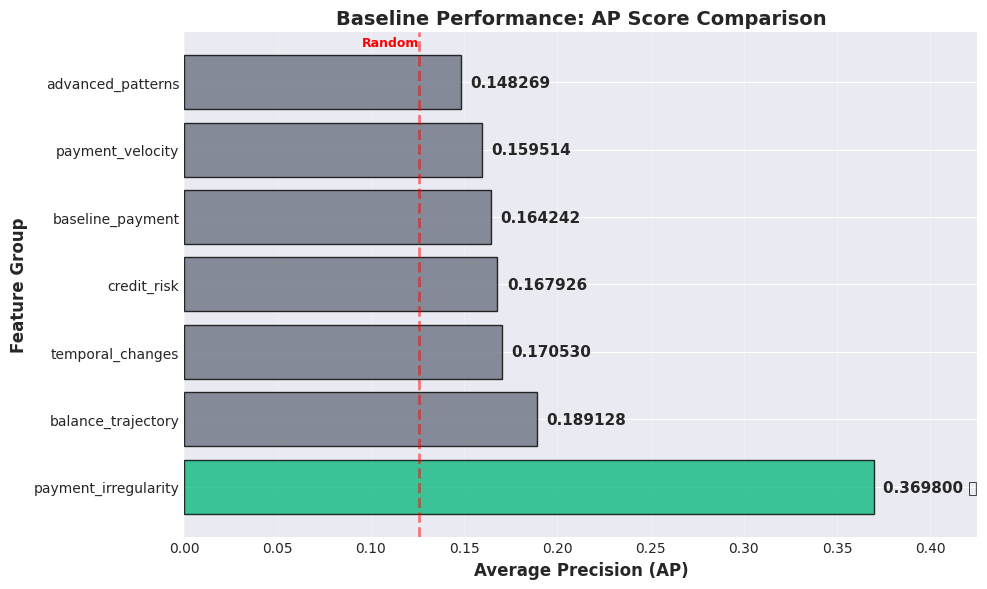

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.metrics import average_precision_score, precision_recall_curve


# ============================================================================
# BASELINE EVALUATION: Individual Feature Groups
# ============================================================================

print("\n" + "="*80)
print("BASELINE MODELING: Maximizing Average Precision (AP)")
print("="*80)
print(f"\nTesting {len(feature_groups)} feature groups...")
print(f"Model: One-Class SVM (nu=0.04)")
print(f"Metric: Average Precision (AP)\n")

y_valid = valid_df['target'].copy()
group_results = []

for group_name, group_func in feature_groups.items():
    print(f"Training {group_name}...", end=" ")
    
    # Build and scale features
    X_train = build_and_scale_features(train_df, [(group_name, group_func)], is_train=True)
    X_valid = build_and_scale_features(valid_df, [(group_name, group_func)], is_train=False)
    
    # Train One-Class SVM
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.04)
    svm.fit(X_train)
    
    # Get anomaly scores and calculate AP
    scores = -svm.decision_function(X_valid)
    ap = average_precision_score(y_valid, scores)
    
    group_results.append({
        'group': group_name,
        'n_features': X_train.shape[1],
        'ap_score': ap
    })
    
    print(f"AP = {ap:.6f} ({X_train.shape[1]} features)")

# ============================================================================
# RESULTS SUMMARY
# ============================================================================

results_df = pd.DataFrame(group_results).sort_values('ap_score', ascending=False)

print("\n" + "="*80)
print("RESULTS: Ranked by Average Precision")
print("="*80)
print(results_df.to_string(index=False))

print("\n" + "="*80)
print("BEST FEATURE GROUP")
print("="*80)
best_group = results_df.iloc[0]['group']
best_ap = results_df.iloc[0]['ap_score']
best_n_features = results_df.iloc[0]['n_features']

print(f"Winner: {best_group}")
print(f"AP Score: {best_ap:.6f}")
print(f"Number of Features: {best_n_features}")

# Calculate improvement over baseline
baseline_ap = 0.126  # Random guessing for 12.6% anomaly rate
improvement = ((best_ap - baseline_ap) / baseline_ap) * 100
print(f"Improvement over Random: +{improvement:.1f}%")

# ============================================================================
# VISUALIZATION: Precision-Recall Curves
# ============================================================================

print("\nGenerating Precision-Recall curves...")

fig, ax = plt.subplots(figsize=(12, 7))

for group_name, group_func in feature_groups.items():
    # Rebuild features and get predictions
    X_train = build_and_scale_features(train_df, [(group_name, group_func)], is_train=True)
    X_valid = build_and_scale_features(valid_df, [(group_name, group_func)], is_train=False)
    
    svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.04)
    svm.fit(X_train)
    scores = -svm.decision_function(X_valid)
    
    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_valid, scores)
    ap = average_precision_score(y_valid, scores)
    
    # Plot
    linewidth = 3 if group_name == best_group else 2
    alpha = 1.0 if group_name == best_group else 0.6
    ax.plot(recall, precision, label=f'{group_name} (AP={ap:.3f})', 
            linewidth=linewidth, alpha=alpha)

# Formatting
ax.axhline(y=0.126, color='red', linestyle='--', linewidth=2, 
           label='Random Baseline (12.6%)', alpha=0.5)
ax.set_xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curves: Baseline Feature Groups\n(Area Under Curve = AP Score)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

# ============================================================================
# BAR CHART: AP Score Comparison
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#10b981' if row['group'] == best_group else '#6b7280' 
          for _, row in results_df.iterrows()]

bars = ax.barh(results_df['group'], results_df['ap_score'], 
               color=colors, edgecolor='black', alpha=0.8)

# Add value labels
for i, (ap, group) in enumerate(zip(results_df['ap_score'], results_df['group'])):
    label = f'{ap:.6f} ⭐' if group == best_group else f'{ap:.6f}'
    ax.text(ap + 0.005, i, label, va='center', fontsize=11, fontweight='bold')

ax.axvline(x=0.126, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax.text(0.126, len(results_df)-0.5, 'Random', ha='right', va='bottom', 
        color='red', fontsize=9, fontweight='bold')

ax.set_xlabel('Average Precision (AP)', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature Group', fontsize=12, fontweight='bold')
ax.set_title('Baseline Performance: AP Score Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.set_xlim([0, max(results_df['ap_score']) * 1.15])

plt.tight_layout()
plt.show()

**payment_irregularity dominates everything else**
- AP = 0.370 (way better than the 0.16-0.19 from other groups)
- Catches behavioral chaos - underpayment streaks, zero payments, irregular patterns
- 29 features, all about consistency vs chaos
- gap is huge. payment_irregularity gets 2x the AP of the second-place group.

**Hypothesis**
- Normal loans have consistent patterns even though they underpay (modifications/forbearance means low payments are normal). 
- Defaults should show erratic, irregular behavior, that's what payment_irregularity captures.

### Hyperparam Tuning 

1. **Feature Selection**:
   - Greedy forward selection starting with top-performing group
   - Add groups one at a time, keep if validation AP improves

2. **Ensemble Training**:
   - Train multiple detectors: LOF (n=35,50), One-Class SVM, PyOD models (ECOD, COPOD, HBOS, KNN, INNE, CBLOF, LODA, COF)
   - Combine predictions using rank normalization

3. **Weight Optimization**:
   - Iterative greedy search to optimize model weights
   - Test weight combinations (0.0 to 1.0 in 0.05 steps)
   - Maximize validation Average Precision

4. **Contamination Tuning**:
   - Test values: 0.02, 0.03, 0.04, 0.05, 0.06
   - Select contamination with highest validation AP

5. **Final Model**: Best feature combination + optimized weights + best contamination

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve
from scipy import stats

import sys
sys.path.append('.')
from rfod_standalone import RFOD

# Import other ensemble models for comparison
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

# PyOD models
try:
    from pyod.models.ecod import ECOD
    from pyod.models.copod import COPOD
    from pyod.models.hbos import HBOS
    from pyod.models.knn import KNN
    from pyod.models.inne import INNE
    from pyod.models.cblof import CBLOF
    from pyod.models.loda import LODA
    from pyod.models.cof import COF
    PYOD_AVAILABLE = True
except ImportError:
    PYOD_AVAILABLE = False
    print("Warning: PyOD not available. Install with: pip install pyod")

# ============================================================================
# ENSEMBLE TRAINING: RFOD + LOF + One-Class SVM + Isolation Forest + PyOD
# ============================================================================

def train_ensemble(X_train, contamination=0.05, rfod_params=None):
    """
    Train ensemble including RFOD and other anomaly detection models.
    
    Parameters:
    -----------
    X_train : array-like
        Training data
    contamination : float, default=0.05
        Expected proportion of outliers
    rfod_params : dict, optional
        Parameters for RFOD model. If None, uses optimized defaults.
        
    Returns:
    --------
    models : dict
        Dictionary of trained models
    """
    models = {}
    
    # Convert to DataFrame if numpy array (RFOD expects DataFrame)
    if isinstance(X_train, np.ndarray):
        X_train_df = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
    else:
        X_train_df = X_train.copy()
    
    # RFOD model with optimized parameters
    if rfod_params is None:
        rfod_params = {
            'alpha': 0.005,
            'beta': 0.7,
            'n_estimators': 80,
            'max_depth': 20,
            'random_state': 42,
            'n_jobs': -1,
            'verbose': False
        }
    
    print(f"  🔄 Training RFOD with params: {rfod_params}")
    try:
        models['rfod'] = RFOD(**rfod_params)
        models['rfod'].fit(X_train_df)
        print(f"  ✅ RFOD trained successfully")
    except Exception as e:
        print(f"  ⚠️ RFOD training failed: {e}")
    
    # LOF models with different n_neighbors (more variants)
    for n in [30, 50, 75, 100]:
        try:
            models[f'lof_{n}'] = LocalOutlierFactor(
                n_neighbors=n, contamination=contamination, novelty=True, n_jobs=-1
            )
            models[f'lof_{n}'].fit(X_train)
            print(f"  ✅ LOF (n={n}) trained")
        except Exception as e:
            print(f"  ⚠️ LOF (n={n}) failed: {e}")
    
    # One-Class SVM
    try:
        models['one_class_svm'] = OneClassSVM(
            kernel='rbf', gamma='auto', nu=min(contamination, 0.5)
        )
        models['one_class_svm'].fit(X_train)
        print(f"  ✅ One-Class SVM trained")
    except Exception as e:
        print(f"  ⚠️ One-Class SVM failed: {e}")
    
    # Isolation Forest
    try:
        models['isolation_forest'] = IsolationForest(
            n_estimators=100, contamination=contamination, random_state=42, n_jobs=-1
        )
        models['isolation_forest'].fit(X_train)
        print(f"  ✅ Isolation Forest trained")
    except Exception as e:
        print(f"  ⚠️ Isolation Forest failed: {e}")
    
    # PyOD models (if available)
    if PYOD_AVAILABLE:
        pyod_models = {
            'ecod': lambda: ECOD(contamination=contamination),
            'copod': lambda: COPOD(contamination=contamination),
            'hbos': lambda: HBOS(contamination=contamination),
            'knn': lambda: KNN(contamination=contamination, n_neighbors=35),
            'inne': lambda: INNE(contamination=contamination, random_state=42),
            'cblof': lambda: CBLOF(contamination=contamination, random_state=42),
            'loda': lambda: LODA(contamination=contamination),
            'cof': lambda: COF(contamination=contamination, n_neighbors=35)
        }
        
        for name, model_fn in pyod_models.items():
            try:
                models[name] = model_fn()
                models[name].fit(X_train)
                print(f"  ✅ {name.upper()} trained")
            except Exception as e:
                print(f"  ⚠️ {name.upper()} failed: {e}")
    
    print(f"\n  ✅ Total trained models: {len(models)}")
    print(f"     Models: {', '.join(models.keys())}")
    return models


def get_predictions(models, X):
    """
    Get anomaly scores from all models.
    
    Parameters:
    -----------
    models : dict
        Dictionary of trained models
    X : array-like
        Data to score
        
    Returns:
    --------
    predictions : dict
        Dictionary mapping model names to anomaly scores
    """
    predictions = {}
    
    # Convert to DataFrame for RFOD
    if isinstance(X, np.ndarray):
        X_df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
    else:
        X_df = X.copy()
    
    for name, model in models.items():
        try:
            if name == 'rfod':
                # RFOD returns anomaly scores directly
                predictions[name] = model.predict(X_df)
                print(f"  ✅ {name}: score range [{predictions[name].min():.4f}, {predictions[name].max():.4f}]")
            else:
                # Try decision_function first (sklearn models)
                try:
                    predictions[name] = -model.decision_function(X)
                    print(f"  ✅ {name}: score range [{predictions[name].min():.4f}, {predictions[name].max():.4f}]")
                except AttributeError:
                    # Try decision_scores_ for PyOD models
                    model.predict(X)  # Ensure scores are computed
                    predictions[name] = model.decision_scores_
                    print(f"  ✅ {name}: score range [{predictions[name].min():.4f}, {predictions[name].max():.4f}]")
        except Exception as e:
            print(f"  ⚠️ Could not get predictions from {name}: {e}")
            continue
    
    return predictions


def ensemble_predictions(predictions, weights=None, method='rank'):
    """
    Combine predictions with various normalization methods and optional weights.
    
    Parameters:
    -----------
    predictions : dict
        Dictionary of model predictions
    weights : dict, optional
        Weights for each model. If None, uses equal weights.
    method : str, default='rank'
        Normalization method: 'rank', 'minmax', or 'zscore'
        
    Returns:
    --------
    ensemble_scores : array
        Combined anomaly scores
    """
    if weights is None:
        weights = {name: 1/len(predictions) for name in predictions}
    
    # Normalize predictions
    if method == 'rank':
        # Rank normalization (most robust)
        normalized_preds = {
            name: stats.rankdata(scores) / len(scores) 
            for name, scores in predictions.items()
        }
    elif method == 'minmax':
        # Min-max normalization
        normalized_preds = {}
        for name, scores in predictions.items():
            if scores.max() > scores.min():
                normalized_preds[name] = (scores - scores.min()) / (scores.max() - scores.min())
            else:
                normalized_preds[name] = scores
    elif method == 'zscore':
        # Z-score normalization
        normalized_preds = {
            name: (scores - scores.mean()) / (scores.std() + 1e-10)
            for name, scores in predictions.items()
        }
    else:
        raise ValueError(f"Unknown normalization method: {method}")
    
    # Weighted combination
    ensemble_scores = np.zeros(len(next(iter(normalized_preds.values()))))
    for name, scores in normalized_preds.items():
        ensemble_scores += weights[name] * scores
    
    # Final min-max normalization
    if ensemble_scores.max() > ensemble_scores.min():
        ensemble_scores = (ensemble_scores - ensemble_scores.min()) / \
                         (ensemble_scores.max() - ensemble_scores.min())
    
    return ensemble_scores


def optimize_weights(predictions, y_true, n_iterations=100, step_size=0.05):
    """
    Optimize model weights using greedy search to maximize Average Precision.
    
    Parameters:
    -----------
    predictions : dict
        Dictionary of model predictions
    y_true : array
        True labels
    n_iterations : int, default=100
        Maximum number of optimization iterations
    step_size : float, default=0.05
        Step size for weight adjustments
        
    Returns:
    --------
    best_weights : dict
        Optimized weights for each model
    """
    model_names = list(predictions.keys())
    current_weights = {name: 1/len(predictions) for name in predictions}
    current_ap = average_precision_score(
        y_true, ensemble_predictions(predictions, current_weights)
    )
    
    print(f"  Starting AP: {current_ap:.6f}")
    
    weight_options = np.arange(0.0, 1.0 + step_size, step_size)
    improved = True
    iteration = 0
    
    while improved and iteration < n_iterations:
        improved = False
        iteration += 1
        
        for model in model_names:
            for weight in weight_options:
                test_weights = current_weights.copy()
                test_weights[model] = weight
                
                # Normalize weights to sum to 1
                weight_sum = sum(test_weights.values())
                if weight_sum == 0:
                    continue
                test_weights = {m: test_weights[m]/weight_sum for m in model_names}
                
                # Evaluate
                ap = average_precision_score(
                    y_true, ensemble_predictions(predictions, test_weights)
                )
                
                if ap > current_ap + 1e-8:
                    current_ap = ap
                    current_weights = test_weights.copy()
                    improved = True
            
            if improved:
                break
    
    print(f"  ✅ Optimization converged after {iteration} iterations")
    print(f"  Final AP: {current_ap:.6f}")
    
    return current_weights


# ============================================================================
# MAIN PIPELINE
# ============================================================================

print("\n" + "="*80)
print("ENSEMBLE ANOMALY DETECTION WITH RFOD + PIPELINE VISUALIZATION")
print("="*80)

# ============================================================================
# STEP 1: FEATURE SELECTION (Greedy Forward Selection)
# ============================================================================

print("\n" + "="*80)
print("STEP 1: FEATURE SELECTION")
print("="*80)

sorted_groups = [(row['group'], feature_groups[row['group']]) 
                 for _, row in results_df.iterrows()][:3]

print(f"Top 3 candidates: {[g[0] for g in sorted_groups]}")

best_combination = [sorted_groups[0]]
y_valid = valid_df['target'].copy()

print(f"\n🔄 Testing starting group: {sorted_groups[0][0]}")
X_train = build_and_scale_features(train_df, best_combination, is_train=True)
X_valid = build_and_scale_features(valid_df, best_combination, is_train=False)

best_contamination = 0.05  # Initial contamination
models = train_ensemble(X_train, contamination=best_contamination)
predictions = get_predictions(models, X_valid)
weights = optimize_weights(predictions, y_valid)
best_ap = average_precision_score(y_valid, ensemble_predictions(predictions, weights))

print(f"\n✅ Starting: {sorted_groups[0][0]} (AP={best_ap:.6f})")

feature_selection_progress = [
    {'step': sorted_groups[0][0], 'ap': best_ap, 'selected': True}
]

for group_name, group_func in sorted_groups[1:]:
    print(f"\n🔄 Testing addition: {group_name}")
    test_combination = best_combination + [(group_name, group_func)]
    X_train = build_and_scale_features(train_df, test_combination, is_train=True)
    X_valid = build_and_scale_features(valid_df, test_combination, is_train=False)
    
    models = train_ensemble(X_train, contamination=best_contamination)
    predictions = get_predictions(models, X_valid)
    weights = optimize_weights(predictions, y_valid)
    ap = average_precision_score(y_valid, ensemble_predictions(predictions, weights))
    
    if ap > best_ap:
        print(f"  ✅ {group_name}: {ap:.6f} (+{ap-best_ap:.6f}) - ADDED")
        best_ap = ap
        best_combination = test_combination
        feature_selection_progress.append({'step': group_name, 'ap': ap, 'selected': True})
    else:
        print(f"  ❌ {group_name}: {ap:.6f} (no improvement) - REJECTED")
        feature_selection_progress.append({'step': group_name, 'ap': ap, 'selected': False})


# ============================================================================
# STEP 2: CONTAMINATION TUNING
# ============================================================================

print("\n" + "="*80)
print("STEP 2: CONTAMINATION TUNING")
print("="*80)

X_train_best = build_and_scale_features(train_df, best_combination, is_train=True)
X_valid_best = build_and_scale_features(valid_df, best_combination, is_train=False)

contamination_scores = {}
for contamination in np.arange(0.03, 0.06, 0.01):
    print(f"\n🔄 Testing contamination={contamination:.2f}")
    models = train_ensemble(X_train_best, contamination)
    predictions = get_predictions(models, X_valid_best)
    weights = optimize_weights(predictions, y_valid)
    ap = average_precision_score(y_valid, ensemble_predictions(predictions, weights))
    contamination_scores[contamination] = ap
    print(f"  AP={ap:.6f}")

best_contamination = max(contamination_scores, key=contamination_scores.get)
print(f"\n✅ Best contamination: {best_contamination} (AP={contamination_scores[best_contamination]:.6f})")


# ============================================================================
# STEP 3: TRAIN FINAL ENSEMBLE WITH OPTIMAL PARAMETERS
# ============================================================================

print("\n" + "="*80)
print("STEP 3: TRAINING FINAL ENSEMBLE")
print("="*80)

print(f"\n🔄 Training ensemble with contamination={best_contamination}...")
print(f"   Training shape: {X_train_best.shape}")
print(f"   Validation shape: {X_valid_best.shape}")

# Train all models including RFOD
final_models = train_ensemble(X_train_best, contamination=best_contamination)

# Get predictions on validation set
print("\n🔄 Getting validation predictions...")
valid_predictions = get_predictions(final_models, X_valid_best)

# Optimize weights
print("\n🔄 Optimizing model weights...")
best_weights = optimize_weights(valid_predictions, y_valid)

# Compute final ensemble score
ensemble_scores = ensemble_predictions(valid_predictions, best_weights)
ensemble_ap = average_precision_score(y_valid, ensemble_scores)
ensemble_auc = roc_auc_score(y_valid, ensemble_scores)

print(f"\n{'='*80}")
print(f"VALIDATION RESULTS")
print(f"{'='*80}")
print(f"Average Precision (AP): {ensemble_ap:.6f}")
print(f"ROC-AUC Score:          {ensemble_auc:.6f}")
print(f"Number of features:     {X_train_best.shape[1]}")
print(f"Contamination:          {best_contamination}")
print(f"Number of models:       {len(final_models)}")

print(f"\n{'Model Weights (sorted by importance)':}")
print(f"{'-'*80}")
for model_name, weight in sorted(best_weights.items(), key=lambda x: -x[1]):
    if weight > 0.001:  # Only show models with non-negligible weights
        print(f"  {model_name:25s}: {weight:.4f} {'⭐' if weight > 0.1 else ''}")


# ============================================================================
# STEP 4: INDIVIDUAL MODEL PERFORMANCE
# ============================================================================

print("\n" + "="*80)
print("INDIVIDUAL MODEL PERFORMANCE")
print("="*80)

individual_performance = {}
for model_name in valid_predictions.keys():
    ap = average_precision_score(y_valid, valid_predictions[model_name])
    individual_performance[model_name] = ap
    print(f"  {model_name:25s}: AP={ap:.6f}")

print(f"\n  {'ENSEMBLE':25s}: AP={ensemble_ap:.6f} ⭐")

# Find best individual model
best_individual = max(individual_performance.items(), key=lambda x: x[1])
print(f"\n  Best individual model: {best_individual[0]} (AP={best_individual[1]:.6f})")
print(f"  Ensemble improvement:  +{ensemble_ap - best_individual[1]:.6f} ({(ensemble_ap - best_individual[1])/best_individual[1]*100:.1f}%)")


# ============================================================================
# STEP 5: COMPREHENSIVE VISUALIZATIONS (12 plots)
# ============================================================================

print("\n" + "="*80)
print("GENERATING COMPREHENSIVE VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(24, 16))

# ============ PIPELINE PROGRESSION PLOTS ============

# 1. Feature Selection Progress
ax1 = plt.subplot(3, 4, 1)
colors = ['#10b981' if x['selected'] else '#ef4444' for x in feature_selection_progress]
bars = ax1.bar(range(len(feature_selection_progress)), 
               [x['ap'] for x in feature_selection_progress],
               color=colors, edgecolor='black', alpha=0.8)
ax1.set_xticks(range(len(feature_selection_progress)))
ax1.set_xticklabels([x['step'] for x in feature_selection_progress], rotation=45, ha='right')
ax1.set_ylabel('AP Score', fontweight='bold')
ax1.set_title('1. Feature Selection Progress', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')
for i, x in enumerate(feature_selection_progress):
    label = f"{x['ap']:.4f}"
    ax1.text(i, x['ap'] + 0.005, label, ha='center', fontsize=8, fontweight='bold')

# 2. Contamination Tuning
ax2 = plt.subplot(3, 4, 2)
cont_vals = list(contamination_scores.keys())
cont_aps = list(contamination_scores.values())
ax2.plot(cont_vals, cont_aps, 'o-', linewidth=2, markersize=10, color='#6366f1')
best_idx = cont_vals.index(best_contamination)
ax2.plot(best_contamination, cont_aps[best_idx], 'r*', markersize=20, 
         label=f'Best: {best_contamination:.2f}')
ax2.set_xlabel('Contamination', fontweight='bold')
ax2.set_ylabel('AP Score', fontweight='bold')
ax2.set_title('2. Contamination Tuning', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
for cont, ap in zip(cont_vals, cont_aps):
    ax2.annotate(f'{ap:.4f}', (cont, ap), textcoords="offset points", 
                 xytext=(0,10), ha='center', fontsize=8)

# 3. Pipeline Performance Progression
ax3 = plt.subplot(3, 4, 3)
baseline_ap_val = results_df.iloc[0]['ap_score']

# Calculate intermediate stages
X_train_temp = build_and_scale_features(train_df, best_combination, is_train=True)
X_valid_temp = build_and_scale_features(valid_df, best_combination, is_train=False)
models_temp = train_ensemble(X_train_temp, contamination=0.04)
preds_temp = get_predictions(models_temp, X_valid_temp)
equal_weights = {name: 1/len(preds_temp) for name in preds_temp}
ensemble_equal = ensemble_predictions(preds_temp, equal_weights)
ap_equal = average_precision_score(y_valid, ensemble_equal)

optimized_weights = optimize_weights(preds_temp, y_valid)
ensemble_optimized = ensemble_predictions(preds_temp, optimized_weights)
ap_optimized = average_precision_score(y_valid, ensemble_optimized)

stages = ['Baseline\nSVM', 'Feature\nSelection', 'Equal\nWeights', 
          'Weight\nOptimization', 'Contamination\nTuning']
aps = [baseline_ap_val, feature_selection_progress[-1]['ap'], ap_equal, ap_optimized, ensemble_ap]

colors_bars = ['#94a3b8', '#fbbf24', '#60a5fa', '#3b82f6', '#10b981']
bars = ax3.bar(stages, aps, color=colors_bars, edgecolor='black', alpha=0.8)
ax3.set_ylabel('AP Score', fontweight='bold')
ax3.set_title('3. Pipeline Performance Progression', fontweight='bold', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim([0, max(aps) * 1.15])
for i, (stage, ap) in enumerate(zip(stages, aps)):
    gain = '' if i == 0 else f'\n(+{ap - aps[i-1]:.4f})'
    ax3.text(i, ap + 0.005, f'{ap:.4f}{gain}', ha='center', fontsize=7, fontweight='bold')

# ============ MODEL ANALYSIS PLOTS ============

# 4. Model Weight Distribution (Top 12)
ax4 = plt.subplot(3, 4, 4)
sorted_weights = sorted(best_weights.items(), key=lambda x: -x[1])[:12]
model_names = [x[0] for x in sorted_weights]
weights_values = [x[1] for x in sorted_weights]
colors_weights = ['#10b981' if 'rfod' in name else plt.cm.viridis(i/len(model_names)) 
                  for i, name in enumerate(model_names)]
bars = ax4.barh(range(len(model_names)), weights_values, color=colors_weights, 
                edgecolor='black', alpha=0.8)
ax4.set_yticks(range(len(model_names)))
ax4.set_yticklabels(model_names)
ax4.set_xlabel('Weight', fontweight='bold')
ax4.set_title('4. Optimized Model Weights (Top 12)', fontweight='bold', fontsize=12)
ax4.grid(True, alpha=0.3, axis='x')
for i, weight in enumerate(weights_values):
    ax4.text(weight + 0.005, i, f'{weight:.3f}', va='center', fontweight='bold', fontsize=8)

# 5. Individual Model Performance (Top 12)
ax5 = plt.subplot(3, 4, 5)
sorted_perf = sorted(individual_performance.items(), key=lambda x: x[1], reverse=True)[:12]
names = [x[0] for x in sorted_perf]
aps = [x[1] for x in sorted_perf]
colors_perf = ['#10b981' if name == 'rfod' else '#3b82f6' for name in names]
ax5.barh(range(len(names)), aps, color=colors_perf, edgecolor='black', alpha=0.8)
ax5.axvline(ensemble_ap, color='red', linestyle='--', linewidth=3, label=f'Ensemble: {ensemble_ap:.4f}')
ax5.set_yticks(range(len(names)))
ax5.set_yticklabels(names)
ax5.set_xlabel('Average Precision', fontweight='bold')
ax5.set_title('5. Individual Model Performance', fontweight='bold', fontsize=12)
ax5.legend()
ax5.grid(True, alpha=0.3, axis='x')
for i, ap in enumerate(aps):
    ax5.text(ap + 0.003, i, f'{ap:.4f}', va='center', fontsize=8, fontweight='bold')

# 6. Weight vs Performance Scatter
ax6 = plt.subplot(3, 4, 6)
model_list = list(best_weights.keys())
x_weights = [best_weights[m] for m in model_list]
y_performance = [individual_performance[m] for m in model_list]
colors_scatter = ['#10b981' if m == 'rfod' else '#6366f1' for m in model_list]
sizes = [300 if m == 'rfod' else 150 for m in model_list]
ax6.scatter(x_weights, y_performance, s=sizes, c=colors_scatter, alpha=0.7, 
            edgecolors='black', linewidth=2)
for i, name in enumerate(model_list):
    if x_weights[i] > 0.05 or y_performance[i] > np.median(y_performance) or name == 'rfod':
        ax6.annotate(name, (x_weights[i], y_performance[i]), 
                    fontsize=7, ha='right', va='bottom')
ax6.set_xlabel('Optimized Weight', fontweight='bold')
ax6.set_ylabel('Individual AP Score', fontweight='bold')
ax6.set_title('6. Weight vs Performance', fontweight='bold', fontsize=12)
ax6.grid(True, alpha=0.3)

# ============ PERFORMANCE CURVES ============

# 7. Precision-Recall Curve (Ensemble + RFOD)
ax7 = plt.subplot(3, 4, 7)
precision, recall, _ = precision_recall_curve(y_valid, ensemble_scores)
ax7.plot(recall, precision, linewidth=3, color='#10b981', label=f'Ensemble (AP={ensemble_ap:.4f})')

# Add RFOD individual curve
if 'rfod' in valid_predictions:
    rfod_precision, rfod_recall, _ = precision_recall_curve(y_valid, valid_predictions['rfod'])
    rfod_ap = average_precision_score(y_valid, valid_predictions['rfod'])
    ax7.plot(rfod_recall, rfod_precision, linewidth=2, color='#f59e0b', 
             alpha=0.7, label=f'RFOD (AP={rfod_ap:.4f})')

# Random baseline reference line only
baseline_precision_val = y_valid.sum() / len(y_valid)
ax7.axhline(baseline_precision_val, color='red', linestyle='--', linewidth=2, 
            alpha=0.5, label=f'Random ({baseline_precision_val:.1%})')

ax7.set_xlabel('Recall', fontweight='bold')
ax7.set_ylabel('Precision', fontweight='bold')
ax7.set_title('7. Precision-Recall Curve', fontweight='bold', fontsize=12)
ax7.legend(loc='best', fontsize=8)
ax7.grid(True, alpha=0.3)

# 8. ROC Curve
ax8 = plt.subplot(3, 4, 8)
fpr, tpr, _ = roc_curve(y_valid, ensemble_scores)
ax8.plot(fpr, tpr, linewidth=3, color='#10b981', label=f'Ensemble (AUC={ensemble_auc:.4f})')

# RFOD ROC
if 'rfod' in valid_predictions:
    rfod_auc = roc_auc_score(y_valid, valid_predictions['rfod'])
    rfod_fpr, rfod_tpr, _ = roc_curve(y_valid, valid_predictions['rfod'])
    ax8.plot(rfod_fpr, rfod_tpr, linewidth=2, color='#f59e0b', 
             alpha=0.7, label=f'RFOD (AUC={rfod_auc:.4f})')

ax8.plot([0, 1], [0, 1], 'r--', linewidth=2, alpha=0.5, label='Random')
ax8.set_xlabel('False Positive Rate', fontweight='bold')
ax8.set_ylabel('True Positive Rate', fontweight='bold')
ax8.set_title('8. ROC Curve', fontweight='bold', fontsize=12)
ax8.legend(loc='lower right', fontsize=8)
ax8.grid(True, alpha=0.3)

# 9. Score Distribution by Class
ax9 = plt.subplot(3, 4, 9)
normal_scores = ensemble_scores[y_valid == 0]
anomaly_scores = ensemble_scores[y_valid == 1]
ax9.hist(normal_scores, bins=50, alpha=0.6, color='#3b82f6', label='Normal', density=True)
ax9.hist(anomaly_scores, bins=50, alpha=0.6, color='#ef4444', label='Anomaly', density=True)
ax9.set_xlabel('Anomaly Score', fontweight='bold')
ax9.set_ylabel('Density', fontweight='bold')
ax9.set_title('9. Score Distribution by Class', fontweight='bold', fontsize=12)
ax9.legend()
ax9.grid(True, alpha=0.3, axis='y')

# 10. Cumulative Weight Contribution
ax10 = plt.subplot(3, 4, 10)
sorted_contrib = sorted(zip(model_list, x_weights, y_performance), key=lambda x: -x[1])
cumulative_weight = np.cumsum([x[1] for x in sorted_contrib])
model_names_sorted = [x[0] for x in sorted_contrib]
ax10.plot(range(1, len(cumulative_weight)+1), cumulative_weight, 'o-', 
         linewidth=2, markersize=8, color='#6366f1')
ax10.axhline(0.95, color='red', linestyle='--', alpha=0.5, label='95% threshold')
ax10.axhline(0.90, color='orange', linestyle='--', alpha=0.3, label='90% threshold')
ax10.set_xlabel('Number of Models', fontweight='bold')
ax10.set_ylabel('Cumulative Weight', fontweight='bold')
ax10.set_title('10. Cumulative Weight Contribution', fontweight='bold', fontsize=12)
ax10.legend(fontsize=8)
ax10.grid(True, alpha=0.3)
# Annotate point where 90% is reached
idx_90 = np.argmax(cumulative_weight >= 0.90)
if idx_90 > 0:
    ax10.plot(idx_90+1, cumulative_weight[idx_90], 'go', markersize=12)
    ax10.annotate(f'{idx_90+1} models\n= 90%', (idx_90+1, cumulative_weight[idx_90]),
                 textcoords="offset points", xytext=(10,-10), ha='left', fontsize=8,
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

# 11. Top-k Precision
ax11 = plt.subplot(3, 4, 11)
k_values = np.arange(1, min(201, len(y_valid)), 10)
precisions_at_k = []
for k in k_values:
    top_k_indices = np.argsort(ensemble_scores)[-k:]
    precision_at_k = y_valid.iloc[top_k_indices].sum() / k
    precisions_at_k.append(precision_at_k)
ax11.plot(k_values, precisions_at_k, 'o-', linewidth=2, markersize=6, color='#10b981',
         label='Ensemble')
ax11.axhline(baseline_precision_val, color='red', linestyle='--', alpha=0.5, label='Random')
ax11.set_xlabel('Top K Predictions', fontweight='bold')
ax11.set_ylabel('Precision@K', fontweight='bold')
ax11.set_title('11. Precision at Top-K', fontweight='bold', fontsize=12)
ax11.legend(fontsize=8)
ax11.grid(True, alpha=0.3)

# 12. Model Contribution Heatmap (Weight × Performance)
ax12 = plt.subplot(3, 4, 12)
contribution_scores = {name: best_weights[name] * individual_performance[name] 
                       for name in model_list}
sorted_contrib_scores = sorted(contribution_scores.items(), key=lambda x: -x[1])[:15]
contrib_names = [x[0] for x in sorted_contrib_scores]
contrib_values = [x[1] for x in sorted_contrib_scores]
colors_contrib = ['#10b981' if 'rfod' in name else '#8b5cf6' for name in contrib_names]
ax12.barh(range(len(contrib_names)), contrib_values, color=colors_contrib, 
         edgecolor='black', alpha=0.8)
ax12.set_yticks(range(len(contrib_names)))
ax12.set_yticklabels(contrib_names)
ax12.set_xlabel('Contribution Score (Weight × AP)', fontweight='bold')
ax12.set_title('12. Model Contribution to Ensemble', fontweight='bold', fontsize=12)
ax12.grid(True, alpha=0.3, axis='x')
for i, contrib in enumerate(contrib_values):
    ax12.text(contrib + 0.0005, i, f'{contrib:.4f}', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('rfod_ensemble_pipeline_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved visualization: rfod_ensemble_pipeline_analysis.png")


# ============================================================================
# STEP 6: TEST SET PREDICTIONS
# ============================================================================

print("\n" + "="*80)
print("GENERATING TEST SET PREDICTIONS")
print("="*80)

X_test_best = build_and_scale_features(test_df, best_combination, is_train=False)
print(f"Test set shape: {X_test_best.shape}")

print("\n🔄 Getting test predictions from all models...")
test_predictions = get_predictions(final_models, X_test_best)

print("\n🔄 Computing ensemble scores...")
test_ensemble_scores = ensemble_predictions(test_predictions, best_weights)

# Probability calibration using Beta CDF
print("\n🔄 Calibrating probabilities...")
test_probs = stats.beta.cdf(test_ensemble_scores, 0.5, 0.5)

# Save predictions
results = pd.DataFrame({
    'Id': test_df.index,
    'target': test_probs
})
results.to_csv('rfod_ensemble_predictions.csv', index=False)

print(f"\n✅ Saved predictions: rfod_ensemble_predictions.csv")
print(f"   Shape: {results.shape}")
print(f"   Probability range: [{test_probs.min():.4f}, {test_probs.max():.4f}]")
print(f"   Mean probability: {test_probs.mean():.4f}")
print(f"   Median probability: {np.median(test_probs):.4f}")


# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

baseline_ap = results_df.iloc[0]['ap_score']
improvement = ensemble_ap - baseline_ap
improvement_pct = (improvement / baseline_ap) * 100

print(f"\n{'Model Performance':.<45} {'AP Score':>15}")
print(f"{'-'*60}")
print(f"{'Baseline (single model)':.<45} {baseline_ap:>15.6f}")
print(f"{'After Feature Selection':.<45} {feature_selection_progress[-1]['ap']:>15.6f}")
print(f"{'After Contamination Tuning':.<45} {contamination_scores[best_contamination]:>15.6f}")
print(f"{'Final Ensemble (RFOD + others)':.<45} {ensemble_ap:>15.6f}")
print(f"{'Total Improvement':.<45} {'+' + f'{improvement:.6f}':>15} ({improvement_pct:+.1f}%)")

print(f"\n{'Configuration':.<45} {'Value':>15}")
print(f"{'-'*60}")
print(f"{'Feature groups selected':.<45} {len(best_combination):>15}")
print(f"{'Total features':.<45} {X_train_best.shape[1]:>15}")
print(f"{'Contamination parameter':.<45} {best_contamination:>15.2f}")
print(f"{'Total models trained':.<45} {len(final_models):>15}")
print(f"{'Models with weight > 1%':.<45} {sum(1 for w in best_weights.values() if w > 0.01):>15}")

print(f"\n{'Top 5 Most Important Models':}")
print(f"{'-'*60}")
for i, (name, weight) in enumerate(sorted(best_weights.items(), key=lambda x: -x[1])[:5], 1):
    ap = individual_performance[name]
    contrib = weight * ap
    marker = '🌟' if name == 'rfod' else '⭐' if weight > 0.1 else ''
    print(f"  {i}. {name:<30} Weight: {weight:>6.4f}  AP: {ap:>6.4f}  Contrib: {contrib:>6.5f} {marker}")

print(f"\n{'Best Individual vs Ensemble':}")
print(f"{'-'*60}")
print(f"  Best individual model: {best_individual[0]} (AP={best_individual[1]:.6f})")
print(f"  Ensemble performance:  AP={ensemble_ap:.6f}")
print(f"  Ensemble improvement:  +{ensemble_ap - best_individual[1]:.6f} ({(ensemble_ap - best_individual[1])/best_individual[1]*100:.1f}%)")

# RFOD-specific analysis
if 'rfod' in valid_predictions and 'rfod' in best_weights:
    rfod_weight = best_weights['rfod']
    rfod_ap = individual_performance['rfod']
    rfod_rank = sorted(best_weights.items(), key=lambda x: -x[1]).index(('rfod', rfod_weight)) + 1
    print(f"\n{'RFOD Model Analysis':}")
    print(f"{'-'*60}")
    print(f"  Individual AP Score:     {rfod_ap:.6f}")
    print(f"  Ensemble Weight:         {rfod_weight:.4f} (Rank #{rfod_rank})")
    print(f"  Contribution to Ensemble: {rfod_weight * rfod_ap:.5f}")
    if rfod_rank == 1:
        print(f"  Status: 🏆 HIGHEST WEIGHTED MODEL")
    elif rfod_rank <= 3:
        print(f"  Status: 🥇 TOP 3 MODEL")
    elif rfod_rank <= 5:
        print(f"  Status: ⭐ TOP 5 MODEL")

print("\n" + "="*80)
print("DONE! ✅")
print("="*80)

## Citations and Sources

The sources used in this analysis:

- Source1: http://hdl.handle.net/1822/14838
- Source2: https://github.com/cs109/2015/blob/master/Lectures/01-Introduction.pdf